In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import datetime # For epoch timing and timestamping
from torchvision import transforms
from collections import deque # For moving average
from dataclasses import dataclass # Added
from typing import List, Optional, Dict, Any # Added

# Your project's specific imports
import config # Your config.py
import models # Your models.py (which should import from diamond_models.ipynb)

# Import dataset from your jetbot_dataset.ipynb
from importnb import Notebook
with Notebook():
    from jetbot_dataset import JetbotDataset # Make sure class name matches

from PIL import Image as PILImage
# import matplotlib.pyplot as plt # Already imported

print("Imports successful.")

Imports successful.


In [2]:
print("--- Configuration ---")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


--- Configuration ---
Using device: cuda


In [3]:
# Denoiser & InnerModel specific
DM_SIGMA_DATA = getattr(config, 'DM_SIGMA_DATA', 0.5)
DM_SIGMA_OFFSET_NOISE = getattr(config, 'DM_SIGMA_OFFSET_NOISE', 0.1)
DM_NOISE_PREVIOUS_OBS = getattr(config, 'DM_NOISE_PREVIOUS_OBS', True)
DM_IMG_CHANNELS = getattr(config, 'DM_IMG_CHANNELS', 3)
DM_NUM_STEPS_CONDITIONING = getattr(config, 'DM_NUM_STEPS_CONDITIONING', config.NUM_PREV_FRAMES)
DM_COND_CHANNELS = getattr(config, 'DM_COND_CHANNELS', 256)
DM_UNET_DEPTHS = getattr(config, 'DM_UNET_DEPTHS', [2, 2, 2, 2])
DM_UNET_CHANNELS = getattr(config, 'DM_UNET_CHANNELS', [128, 256, 512, 1024]) # Using config.py
DM_UNET_ATTN_DEPTHS = getattr(config, 'DM_UNET_ATTN_DEPTHS', [False, False, True, True])
DM_NUM_ACTIONS = getattr(config, 'DM_NUM_ACTIONS', 2)
DM_IS_UPSAMPLER = getattr(config, 'DM_IS_UPSAMPLER', False)
DM_UPSAMPLING_FACTOR = getattr(config, 'DM_UPSAMPLING_FACTOR', None)

# Sampler specific (for inference/visualization)
SAMPLER_NUM_STEPS = getattr(config, 'SAMPLER_NUM_STEPS', 50)
SAMPLER_SIGMA_MIN = getattr(config, 'SAMPLER_SIGMA_MIN', 0.002)
SAMPLER_SIGMA_MAX = getattr(config, 'SAMPLER_SIGMA_MAX', 80.0)
SAMPLER_RHO = getattr(config, 'SAMPLER_RHO', 7.0)
# Additional Karras sampler params from config if they exist, otherwise defaults in dataclass used
SAMPLER_ORDER = getattr(config, 'SAMPLER_ORDER', 1)
SAMPLER_S_CHURN = getattr(config, 'SAMPLER_S_CHURN', 0.0)
SAMPLER_S_TMIN = getattr(config, 'SAMPLER_S_TMIN', 0.0)
SAMPLER_S_TMAX = getattr(config, 'SAMPLER_S_TMAX', float("inf"))
SAMPLER_S_NOISE = getattr(config, 'SAMPLER_S_NOISE', 1.0)


# Training specific
BATCH_SIZE = config.BATCH_SIZE
LEARNING_RATE = config.LEARNING_RATE
NUM_EPOCHS = config.NUM_EPOCHS
SAVE_MODEL_EVERY = config.SAVE_MODEL_EVERY
SAMPLE_EVERY = config.SAMPLE_EVERY
PLOT_EVERY = config.PLOT_EVERY
GRAD_CLIP_VALUE = getattr(config, 'GRAD_CLIP_VALUE', 1.0)

DM_SIGMA_P_MEAN = getattr(config, 'DM_SIGMA_P_MEAN', -1.2) 
DM_SIGMA_P_STD = getattr(config, 'DM_SIGMA_P_STD', 1.2)   
DM_SIGMA_MIN_TRAIN = getattr(config, 'DM_SIGMA_MIN_TRAIN', 0.002) 
DM_SIGMA_MAX_TRAIN = getattr(config, 'DM_SIGMA_MAX_TRAIN', 80.0)  

EARLY_STOPPING_PATIENCE = getattr(config, 'EARLY_STOPPING_PATIENCE', 10)
EARLY_STOPPING_MIN_EPOCHS = getattr(config, 'MIN_EPOCHS', 20) # Renamed from MIN_EPOCHS in config to avoid ambiguity
EARLY_STOPPING_PERCENTAGE = getattr(config, 'EARLY_STOPPING_PERCENTAGE', 0.1) 
TRAIN_MOVING_AVG_WINDOW = getattr(config, 'TRAIN_MOVING_AVG_WINDOW', 10) 
VAL_MOVING_AVG_WINDOW = getattr(config, 'VAL_MOVING_AVG_WINDOW', 5) 

print("Configuration loaded.")

Configuration loaded.


In [4]:
data_transform = config.TRANSFORM

full_dataset = JetbotDataset(
    csv_path=config.CSV_PATH,
    data_dir=config.DATA_DIR,
    image_size=config.IMAGE_SIZE,
    num_prev_frames=config.NUM_PREV_FRAMES,
    transform=data_transform
)
print(f"Full dataset size: {len(full_dataset)}")

split_file_path = os.path.join(config.OUTPUT_DIR, getattr(config, 'SPLIT_DATASET_FILENAME', 'dataset_split.pth'))
if os.path.exists(split_file_path):
    print(f"Loading dataset split from {split_file_path}")
    split_data = torch.load(split_file_path)
    train_indices, val_indices = split_data['train_indices'], split_data['val_indices']
    train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
else:
    print("Creating new train/val split...")
    total_size = len(full_dataset)
    train_size = int(total_size * 0.9)
    val_size = total_size - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size]) # Using torch.random_split by default
    torch.save({
        'train_indices': train_dataset.indices,
        'val_indices': val_dataset.indices,
    }, split_file_path)
    print(f"Saved new dataset split to {split_file_path}")

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Train Dataloader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Validation Dataloader: {len(val_dataloader)} batches of size {BATCH_SIZE}")

Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Full dataset size: 3803
Loading dataset split from C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\dataset_split.pth
Training dataset size: 3422
Validation dataset size: 381
Train Dataloader: 855 batches of size 4
Validation Dataloader: 96 batches of size 4


In [5]:
print("--- Initializing Models ---")

# 1. InnerModel (U-Net part of the Denoiser)
try:
    inner_model_config = models.InnerModelConfig( # This is diamond_models.InnerModelConfig
        img_channels=DM_IMG_CHANNELS,
        num_steps_conditioning=DM_NUM_STEPS_CONDITIONING, # This is NUM_PREV_FRAMES
        cond_channels=DM_COND_CHANNELS,
        depths=DM_UNET_DEPTHS,
        channels=DM_UNET_CHANNELS,
        attn_depths=DM_UNET_ATTN_DEPTHS,
        num_actions=DM_NUM_ACTIONS, # From config, e.g., 2 for JetBot
        is_upsampler=DM_IS_UPSAMPLER # Will be set by DenoiserConfig later too
    )
    inner_model_instance = models.InnerModel(inner_model_config).to(DEVICE) # diamond_models.InnerModelImpl
    print("Using InnerModel (Diamond-style U-Net) as the inner model.")
    print(f"InnerModelImpl parameter count: {sum(p.numel() for p in inner_model_instance.parameters() if p.requires_grad):,}")
except Exception as e:
    print(f"Could not instantiate InnerModelImpl due to: {e}. Ensure 'InnerModelConfig', 'InnerModelImpl', dependencies, and DM_* config parameters are correct.")
    raise

# 2. Denoiser (using diamond_models.Denoiser)
try:
    denoiser_cfg = models.DenoiserConfig( # Our new dataclass
        inner_model=inner_model_config, # Pass the config, not the instance here if Denoiser instantiates it.
                                        # diamond_models.Denoiser takes an InnerModelConfig for its own InnerModel.
                                        # Re-checking diamond_models.py: Denoiser.__init__(self, cfg: DenoiserConfig)
                                        # cfg.inner_model.is_upsampler = self.is_upsampler
                                        # self.inner_model = InnerModel(cfg.inner_model) <--- Correct, it expects InnerModelConfig in DenoiserConfig
        sigma_data=DM_SIGMA_DATA,
        sigma_offset_noise=DM_SIGMA_OFFSET_NOISE,
        noise_previous_obs=DM_NOISE_PREVIOUS_OBS,
        upsampling_factor=DM_UPSAMPLING_FACTOR
    )
    # Ensure DenoiserConfig's inner_model field matches diamond_models.InnerModelConfig type
    # The `models.InnerModelConfig` is already an alias to `diamond_models.InnerModelConfig`
    denoiser = models.Denoiser(cfg=denoiser_cfg).to(DEVICE) # Pass the config object
    
    # Setup training sigma distribution for the Denoiser
    sigma_dist_train_cfg = models.SigmaDistributionConfig(
        loc=DM_SIGMA_P_MEAN,
        scale=DM_SIGMA_P_STD,
        sigma_min=DM_SIGMA_MIN_TRAIN,
        sigma_max=DM_SIGMA_MAX_TRAIN
    )
    denoiser.setup_training(sigma_dist_train_cfg) # Call setup_training
    print(f"Denoiser model created and training sigma distribution configured. Total parameter count: {sum(p.numel() for p in denoiser.parameters() if p.requires_grad):,}")

except Exception as e:
    print(f"Could not instantiate or configure Denoiser (from diamond_models.py) due to: {e}.")
    raise

# 3. DiffusionSampler (using diamond_models.DiffusionSampler)
try:
    sampler_cfg = models.DiffusionSamplerConfig( # Our new dataclass
        num_steps_denoising=SAMPLER_NUM_STEPS,
        sigma_min=SAMPLER_SIGMA_MIN,
        sigma_max=SAMPLER_SIGMA_MAX,
        rho=SAMPLER_RHO,
        order=SAMPLER_ORDER,
        s_churn=SAMPLER_S_CHURN,
        s_tmin=SAMPLER_S_TMIN,
        s_tmax=SAMPLER_S_TMAX,
        s_noise=SAMPLER_S_NOISE
    )
    diffusion_sampler = models.DiffusionSampler( # This is diamond_models.DiffusionSampler
        denoiser=denoiser, # Pass the denoiser instance
        cfg=sampler_cfg    # Pass the sampler config object
    ) # Sampler itself might not need .to(DEVICE) if it doesn't have parameters
    print("DiffusionSampler created for visualization.")
except Exception as e:
    print(f"Could not instantiate DiffusionSampler (from diamond_models.py) due to: {e}.")
    raise


--- Initializing Models ---
Using InnerModel (Diamond-style U-Net) as the inner model.
InnerModelImpl parameter count: 227,699,203
Denoiser model created and training sigma distribution configured. Total parameter count: 227,699,203
DiffusionSampler created for visualization.


In [6]:
print("--- Setting up Optimizer ---")
optimizer = torch.optim.AdamW(denoiser.parameters(), lr=LEARNING_RATE)
lr_scheduler = None # Placeholder
print(f"Optimizer: AdamW with LR={LEARNING_RATE}")

--- Setting up Optimizer ---
Optimizer: AdamW with LR=5e-05


In [7]:
START_EPOCH = 0
BEST_TRAIN_LOSS_MA_FROM_CKPT = float('inf')
PREVIOUS_BEST_TRAIN_MODEL_PATH = None

# Correctly use LOAD_CHECKPOINT from config.py for the specific path
load_path_config = config.LOAD_CHECKPOINT 
best_train_loss_model_default_path = os.path.join(config.CHECKPOINT_DIR, "denoiser_model_best_train_loss.pth")

load_path = load_path_config
if load_path: # If a specific path is set in config, use it
    print(f"Attempting to load checkpoint from config.LOAD_CHECKPOINT: {load_path}")
elif os.path.exists(best_train_loss_model_default_path): # Else, try the default best
    load_path = best_train_loss_model_default_path
    print(f"No specific checkpoint in config.LOAD_CHECKPOINT. Found existing best_train_loss model: {load_path}")


if load_path and os.path.exists(load_path):
    print(f"Loading checkpoint from: {load_path}")
    try:
        checkpoint = torch.load(load_path, map_location=DEVICE)
        denoiser.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        START_EPOCH = checkpoint.get('epoch', 0) + 1
        BEST_TRAIN_LOSS_MA_FROM_CKPT = checkpoint.get('best_train_loss_ma', float('inf'))
        if load_path.endswith("denoiser_model_best_train_loss.pth"): # Ensure we track the correct one
            PREVIOUS_BEST_TRAIN_MODEL_PATH = load_path
        print(f"Resuming training from epoch {START_EPOCH}. Last best train_loss_ma: {BEST_TRAIN_LOSS_MA_FROM_CKPT:.6f}")
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Starting from scratch.")
        START_EPOCH = 0; BEST_TRAIN_LOSS_MA_FROM_CKPT = float('inf')
else:
    if load_path_config: # If a path was specified but not found
        print(f"Specified checkpoint not found: {load_path_config}. Starting from scratch.")
    else: # No checkpoint specified and default best not found
        print("No checkpoint found or specified. Starting from scratch.")


No checkpoint found or specified. Starting from scratch.


In [8]:
def tensor_to_pil(tensor_img):
    tensor_img = (tensor_img.clamp(-1, 1) + 1) / 2
    tensor_img = tensor_img.detach().cpu().permute(1, 2, 0).numpy()
    if tensor_img.shape[2] == 1:
        tensor_img = tensor_img.squeeze(2)
    # Ensure array is writeable for PIL
    if not tensor_img.flags.writeable:
        tensor_img = np.ascontiguousarray(tensor_img)
    if tensor_img.dtype != np.uint8: # This check might be problematic if tensor_img is already uint8
        pil_img_array = (tensor_img * 255).astype(np.uint8)
    else:
        pil_img_array = tensor_img # Already uint8
    pil_img = PILImage.fromarray(pil_img_array)
    return pil_img

def save_visualization_samples(generated_tensors, gt_tensors, epoch, save_dir, max_imgs=4, prefix="train_vis"):
    os.makedirs(save_dir, exist_ok=True)
    num_samples_to_show = min(max_imgs, generated_tensors.shape[0], gt_tensors.shape[0])
    if num_samples_to_show == 0: return

    generated_tensors = generated_tensors[:num_samples_to_show]
    gt_tensors = gt_tensors[:num_samples_to_show]

    fig_height = 6
    fig, axs = plt.subplots(2, num_samples_to_show, figsize=(num_samples_to_show * 3, fig_height))
    if num_samples_to_show == 1: axs = np.array(axs).reshape(2,1) # Ensure axs is always 2D array

    for i in range(num_samples_to_show):
        try:
            gen_pil = tensor_to_pil(generated_tensors[i])
            gt_pil = tensor_to_pil(gt_tensors[i])
            axs[0, i].imshow(gt_pil); axs[0, i].set_title(f"GT {i+1}"); axs[0, i].axis('off')
            axs[1, i].imshow(gen_pil); axs[1, i].set_title(f"Gen {i+1}"); axs[1, i].axis('off')
        except Exception as e:
            print(f"Error visualizing image {i}: {e}")
            if num_samples_to_show > 1 : axs[0,i].axis('off'); axs[1,i].axis('off')
            else: fig.clear(); plt.text(0.5, 0.5, "Error displaying image", ha="center", va="center")

    plt.tight_layout()
    save_path = os.path.join(save_dir, f"{prefix}_epoch_{epoch:04d}_samples.png")
    plt.savefig(save_path)
    plt.close(fig)
    print(f"Saved visualization samples to {save_path}")

print("Visualization helpers defined.")

Visualization helpers defined.


In [9]:
def train_denoiser_epoch(denoiser_model, train_dl, opt, grad_clip_val, device, epoch_num_for_log=""):
    denoiser_model.train()
    total_loss = 0.0
    progress_bar = tqdm(train_dl, desc=f"Epoch {epoch_num_for_log} [Train]", leave=False)
    
    # Constants for reshaping and preparing Batch object
    num_prev_frames = config.NUM_PREV_FRAMES
    c, h, w = DM_IMG_CHANNELS, config.IMAGE_SIZE, config.IMAGE_SIZE
    
    for batch_idx, (target_img_batch, action_batch, prev_frames_flat_batch) in enumerate(progress_bar):
        opt.zero_grad()
        
        current_batch_size = target_img_batch.shape[0] # Handle last batch if drop_last=False

        # Move data to device
        target_img_batch = target_img_batch.to(device) # (B, C, H, W)
        action_batch = action_batch.to(device)         # (B, 1)
        prev_frames_flat_batch = prev_frames_flat_batch.to(device) # (B, NumPrevFrames*C, H, W)

        # 1. Prepare Batch.obs: (B, NumPrevFrames + 1, C, H, W)
        prev_frames_seq_batch = prev_frames_flat_batch.view(current_batch_size, num_prev_frames, c, h, w)
        batch_obs_tensor = torch.cat((prev_frames_seq_batch, target_img_batch.unsqueeze(1)), dim=1)

        # 2. Prepare Batch.act: (B, NumPrevFrames)
        # Tiling the single action from dataloader to match NUM_PREV_FRAMES.
        # This is a simplification; ideally, dataset provides action history.
        batch_act_tensor = action_batch.repeat(1, num_prev_frames).long() # Ensure actions are long for embedding
        
        # 3. Prepare Batch.mask_padding (Optional, defaults to all valid if None)
        # Denoiser uses mask_padding[:, n+i], so it's (B, T). Let's assume all data is valid.
        batch_mask_padding = torch.ones(current_batch_size, num_prev_frames + 1, device=device, dtype=torch.bool)

        # Create Batch object
        current_batch_obj = models.Batch(
            obs=batch_obs_tensor, 
            act=batch_act_tensor, 
            mask_padding=batch_mask_padding
            # info=None # Not used for this non-upsampler case
        )
        
        # Denoiser.forward expects a Batch object and returns (loss, logs_dict)
        loss, logs = denoiser_model(current_batch_obj) 
        
        loss.backward()
        if grad_clip_val > 0: torch.nn.utils.clip_grad_norm_(denoiser_model.parameters(), grad_clip_val)
        opt.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item(), "DenoisingLoss": logs.get("loss_denoising", "N/A")})
        
    return total_loss / len(train_dl) if len(train_dl) > 0 else 0

@torch.no_grad()
def validate_denoiser_epoch(denoiser_model, val_dl, device, epoch_num_for_log=""):
    denoiser_model.eval()
    total_loss = 0.0
    progress_bar = tqdm(val_dl, desc=f"Epoch {epoch_num_for_log} [Valid]", leave=False)

    num_prev_frames = config.NUM_PREV_FRAMES
    c, h, w = DM_IMG_CHANNELS, config.IMAGE_SIZE, config.IMAGE_SIZE

    for batch_idx, (target_img_batch, action_batch, prev_frames_flat_batch) in enumerate(progress_bar):
        current_batch_size = target_img_batch.shape[0]

        target_img_batch = target_img_batch.to(device)
        action_batch = action_batch.to(device)
        prev_frames_flat_batch = prev_frames_flat_batch.to(device)

        prev_frames_seq_batch = prev_frames_flat_batch.view(current_batch_size, num_prev_frames, c, h, w)
        batch_obs_tensor = torch.cat((prev_frames_seq_batch, target_img_batch.unsqueeze(1)), dim=1)
        batch_act_tensor = action_batch.repeat(1, num_prev_frames).long()
        batch_mask_padding = torch.ones(current_batch_size, num_prev_frames + 1, device=device, dtype=torch.bool)

        current_batch_obj = models.Batch(
            obs=batch_obs_tensor, 
            act=batch_act_tensor, 
            mask_padding=batch_mask_padding
        )
        
        loss, logs = denoiser_model(current_batch_obj)
        total_loss += loss.item()
        progress_bar.set_postfix({"Val Loss": loss.item(), "DenoisingLoss": logs.get("loss_denoising", "N/A")})
        
    return total_loss / len(val_dl) if len(val_dl) > 0 else 0

print("Training and validation epoch functions adapted for Batch object and Denoiser.forward.")


Training and validation epoch functions adapted for Batch object and Denoiser.forward.


--- Starting Training Process ---


Epoch 1 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 1 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 1/1000 - Train Loss: 0.2870 (MA: 0.2870), Val Loss: 0.1077 (MA: 0.1077), Duration: 0:02:55.759027
Epoch 1: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0001_samples.png


Epoch 2 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 2 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 2/1000 - Train Loss: 0.0988 (MA: 0.1929), Val Loss: 0.0746 (MA: 0.0911), Duration: 0:02:55.136283
Epoch 2: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0002_samples.png


Epoch 3 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 3 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 3/1000 - Train Loss: 0.0676 (MA: 0.1511), Val Loss: 0.0628 (MA: 0.0817), Duration: 0:02:54.921615
Epoch 3: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0003_samples.png


Epoch 4 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 4 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 4/1000 - Train Loss: 0.0557 (MA: 0.1273), Val Loss: 0.0519 (MA: 0.0743), Duration: 0:02:56.752026
Epoch 4: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0004_samples.png


Epoch 5 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 5 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 5/1000 - Train Loss: 0.0459 (MA: 0.1110), Val Loss: 0.0399 (MA: 0.0674), Duration: 0:02:56.114881
Epoch 5: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0005_samples.png


Epoch 6 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 6 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 6/1000 - Train Loss: 0.0418 (MA: 0.0994), Val Loss: 0.0486 (MA: 0.0555), Duration: 0:02:56.334027
  Train Loss MA improved to 0.099449 from inf (nan% improvement).
  Saved new best model (train loss MA) at epoch 6
Epoch 6: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0006_samples.png


Epoch 7 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 7 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 7/1000 - Train Loss: 0.0387 (MA: 0.0908), Val Loss: 0.0418 (MA: 0.0490), Duration: 0:02:56.224353
  Train Loss MA improved to 0.090772 from 0.099449 (8.73% improvement).
  Saved new best model (train loss MA) at epoch 7
Epoch 7: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0007_samples.png


Epoch 8 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 8 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 8/1000 - Train Loss: 0.0344 (MA: 0.0837), Val Loss: 0.0339 (MA: 0.0432), Duration: 0:02:56.043547
  Train Loss MA improved to 0.083721 from 0.090772 (7.77% improvement).
  Saved new best model (train loss MA) at epoch 8
Epoch 8: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0008_samples.png


Epoch 9 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 9 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 9/1000 - Train Loss: 0.0324 (MA: 0.0780), Val Loss: 0.0284 (MA: 0.0385), Duration: 0:02:55.831062
  Train Loss MA improved to 0.078021 from 0.083721 (6.81% improvement).
  Saved new best model (train loss MA) at epoch 9
Epoch 9: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0009_samples.png


Epoch 10 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 10 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 10/1000 - Train Loss: 0.0319 (MA: 0.0734), Val Loss: 0.0297 (MA: 0.0365), Duration: 0:02:55.855706
  Train Loss MA improved to 0.073410 from 0.078021 (5.91% improvement).
  Saved new best model (train loss MA) at epoch 10
Epoch 10: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0010_samples.png
Saved loss plot up to epoch 10


Epoch 11 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 11 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 11/1000 - Train Loss: 0.0279 (MA: 0.0475), Val Loss: 0.0267 (MA: 0.0321), Duration: 0:02:56.120544
  Train Loss MA improved to 0.047506 from 0.073410 (35.29% improvement).
  Saved new best model (train loss MA) at epoch 11
Epoch 11: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0011_samples.png


Epoch 12 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 12 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 12/1000 - Train Loss: 0.0271 (MA: 0.0403), Val Loss: 0.0291 (MA: 0.0296), Duration: 0:02:56.380753
  Train Loss MA improved to 0.040336 from 0.047506 (15.09% improvement).
  Saved new best model (train loss MA) at epoch 12
Epoch 12: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0012_samples.png


Epoch 13 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 13 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 13/1000 - Train Loss: 0.0270 (MA: 0.0363), Val Loss: 0.0262 (MA: 0.0280), Duration: 0:02:56.232068
  Train Loss MA improved to 0.036268 from 0.040336 (10.08% improvement).
  Saved new best model (train loss MA) at epoch 13
Epoch 13: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0013_samples.png


Epoch 14 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 14 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 14/1000 - Train Loss: 0.0247 (MA: 0.0332), Val Loss: 0.0232 (MA: 0.0270), Duration: 0:02:56.289024
  Train Loss MA improved to 0.033165 from 0.036268 (8.56% improvement).
  Saved new best model (train loss MA) at epoch 14
Epoch 14: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0014_samples.png


Epoch 15 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 15 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 15/1000 - Train Loss: 0.0242 (MA: 0.0310), Val Loss: 0.0235 (MA: 0.0258), Duration: 0:02:55.935761
  Train Loss MA improved to 0.031004 from 0.033165 (6.51% improvement).
  Saved new best model (train loss MA) at epoch 15
Epoch 15: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0015_samples.png


Epoch 16 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 16 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 16/1000 - Train Loss: 0.0234 (MA: 0.0292), Val Loss: 0.0240 (MA: 0.0252), Duration: 0:02:55.960032
  Train Loss MA improved to 0.029168 from 0.031004 (5.92% improvement).
  Saved new best model (train loss MA) at epoch 16
Epoch 16: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0016_samples.png


Epoch 17 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 17 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 17/1000 - Train Loss: 0.0227 (MA: 0.0276), Val Loss: 0.0247 (MA: 0.0243), Duration: 0:02:57.655479
  Train Loss MA improved to 0.027565 from 0.029168 (5.50% improvement).
  Saved new best model (train loss MA) at epoch 17
Epoch 17: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0017_samples.png


Epoch 18 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 18 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 18/1000 - Train Loss: 0.0223 (MA: 0.0264), Val Loss: 0.0218 (MA: 0.0235), Duration: 0:02:55.451020
  Train Loss MA improved to 0.026356 from 0.027565 (4.39% improvement).
  Saved new best model (train loss MA) at epoch 18
Epoch 18: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0018_samples.png


Epoch 19 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 19 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 19/1000 - Train Loss: 0.0229 (MA: 0.0254), Val Loss: 0.0215 (MA: 0.0231), Duration: 0:02:55.116560
  Train Loss MA improved to 0.025408 from 0.026356 (3.60% improvement).
  Saved new best model (train loss MA) at epoch 19
Epoch 19: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0019_samples.png


Epoch 20 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 20 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 20/1000 - Train Loss: 0.0212 (MA: 0.0243), Val Loss: 0.0206 (MA: 0.0225), Duration: 0:02:55.317284
  Train Loss MA improved to 0.024340 from 0.025408 (4.20% improvement).
  Saved new best model (train loss MA) at epoch 20
Epoch 20: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0020_samples.png
Saved loss plot up to epoch 20


Epoch 21 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 21 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 21/1000 - Train Loss: 0.0204 (MA: 0.0236), Val Loss: 0.0212 (MA: 0.0219), Duration: 0:02:55.275581
  Train Loss MA improved to 0.023588 from 0.024340 (3.09% improvement).
  Saved new best model (train loss MA) at epoch 21
Epoch 21: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0021_samples.png


Epoch 22 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 22 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 22/1000 - Train Loss: 0.0211 (MA: 0.0230), Val Loss: 0.0205 (MA: 0.0211), Duration: 0:02:55.204795
  Train Loss MA improved to 0.022993 from 0.023588 (2.52% improvement).
  Saved new best model (train loss MA) at epoch 22
Epoch 22: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0022_samples.png


Epoch 23 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 23 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 23/1000 - Train Loss: 0.0205 (MA: 0.0223), Val Loss: 0.0219 (MA: 0.0211), Duration: 0:02:55.425035
  Train Loss MA improved to 0.022346 from 0.022993 (2.81% improvement).
  Saved new best model (train loss MA) at epoch 23
Epoch 23: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0023_samples.png


Epoch 24 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 24 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 24/1000 - Train Loss: 0.0198 (MA: 0.0219), Val Loss: 0.0191 (MA: 0.0207), Duration: 0:02:55.401557
  Train Loss MA improved to 0.021864 from 0.022346 (2.16% improvement).
  Saved new best model (train loss MA) at epoch 24
Epoch 24: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0024_samples.png


Epoch 25 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 25 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 25/1000 - Train Loss: 0.0188 (MA: 0.0213), Val Loss: 0.0181 (MA: 0.0202), Duration: 0:02:55.215060
  Train Loss MA improved to 0.021320 from 0.021864 (2.49% improvement).
  Saved new best model (train loss MA) at epoch 25
Epoch 25: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0025_samples.png


Epoch 26 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 26 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 26/1000 - Train Loss: 0.0191 (MA: 0.0209), Val Loss: 0.0191 (MA: 0.0198), Duration: 0:02:55.186038
  Train Loss MA improved to 0.020895 from 0.021320 (2.00% improvement).
  Saved new best model (train loss MA) at epoch 26
Epoch 26: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0026_samples.png


Epoch 27 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 27 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 27/1000 - Train Loss: 0.0186 (MA: 0.0205), Val Loss: 0.0234 (MA: 0.0203), Duration: 0:02:55.114212
  Train Loss MA improved to 0.020488 from 0.020895 (1.95% improvement).
  Saved new best model (train loss MA) at epoch 27
Epoch 27: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0027_samples.png


Epoch 28 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 28 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 28/1000 - Train Loss: 0.0179 (MA: 0.0200), Val Loss: 0.0179 (MA: 0.0195), Duration: 0:02:55.316236
  Train Loss MA improved to 0.020049 from 0.020488 (2.14% improvement).
  Saved new best model (train loss MA) at epoch 28
Epoch 28: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0028_samples.png


Epoch 29 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 29 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 29/1000 - Train Loss: 0.0192 (MA: 0.0197), Val Loss: 0.0191 (MA: 0.0195), Duration: 0:02:55.237122
  Train Loss MA improved to 0.019673 from 0.020049 (1.87% improvement).
  Saved new best model (train loss MA) at epoch 29
Epoch 29: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0029_samples.png


Epoch 30 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 30 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 30/1000 - Train Loss: 0.0180 (MA: 0.0194), Val Loss: 0.0175 (MA: 0.0194), Duration: 0:02:55.627740
  Train Loss MA improved to 0.019354 from 0.019673 (1.62% improvement).
  Saved new best model (train loss MA) at epoch 30
Epoch 30: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0030_samples.png
Saved loss plot up to epoch 30


Epoch 31 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 31 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 31/1000 - Train Loss: 0.0171 (MA: 0.0190), Val Loss: 0.0181 (MA: 0.0192), Duration: 0:02:55.378555
  Train Loss MA improved to 0.019027 from 0.019354 (1.69% improvement).
  Saved new best model (train loss MA) at epoch 31
Epoch 31: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0031_samples.png


Epoch 32 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 32 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 32/1000 - Train Loss: 0.0177 (MA: 0.0187), Val Loss: 0.0212 (MA: 0.0188), Duration: 0:02:55.174545
  Train Loss MA improved to 0.018683 from 0.019027 (1.81% improvement).
  Saved new best model (train loss MA) at epoch 32
Epoch 32: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0032_samples.png


Epoch 33 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 33 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 33/1000 - Train Loss: 0.0177 (MA: 0.0184), Val Loss: 0.0191 (MA: 0.0190), Duration: 0:02:55.108260
  Train Loss MA improved to 0.018401 from 0.018683 (1.51% improvement).
  Saved new best model (train loss MA) at epoch 33
Epoch 33: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0033_samples.png


Epoch 34 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 34 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 34/1000 - Train Loss: 0.0171 (MA: 0.0181), Val Loss: 0.0184 (MA: 0.0189), Duration: 0:02:55.476013
  Train Loss MA improved to 0.018132 from 0.018401 (1.47% improvement).
  Saved new best model (train loss MA) at epoch 34
Epoch 34: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0034_samples.png


Epoch 35 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 35 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 35/1000 - Train Loss: 0.0177 (MA: 0.0180), Val Loss: 0.0185 (MA: 0.0191), Duration: 0:02:55.163927
  Train Loss MA improved to 0.018018 from 0.018132 (0.63% improvement).
  Saved new best model (train loss MA) at epoch 35
Epoch 35: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0035_samples.png


Epoch 36 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 36 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 36/1000 - Train Loss: 0.0168 (MA: 0.0178), Val Loss: 0.0223 (MA: 0.0199), Duration: 0:02:55.156975
  Train Loss MA improved to 0.017789 from 0.018018 (1.27% improvement).
  Saved new best model (train loss MA) at epoch 36
Epoch 36: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0036_samples.png


Epoch 37 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 37 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 37/1000 - Train Loss: 0.0159 (MA: 0.0175), Val Loss: 0.0186 (MA: 0.0194), Duration: 0:02:55.350836
  Train Loss MA improved to 0.017518 from 0.017789 (1.52% improvement).
  Saved new best model (train loss MA) at epoch 37
Epoch 37: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0037_samples.png


Epoch 38 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 38 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 38/1000 - Train Loss: 0.0165 (MA: 0.0174), Val Loss: 0.0175 (MA: 0.0191), Duration: 0:02:55.120418
  Train Loss MA improved to 0.017383 from 0.017518 (0.77% improvement).
  Saved new best model (train loss MA) at epoch 38
Epoch 38: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0038_samples.png


Epoch 39 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 39 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 39/1000 - Train Loss: 0.0162 (MA: 0.0171), Val Loss: 0.0189 (MA: 0.0192), Duration: 0:02:55.150594
  Train Loss MA improved to 0.017087 from 0.017383 (1.70% improvement).
  Saved new best model (train loss MA) at epoch 39
Epoch 39: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0039_samples.png


Epoch 40 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 40 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 40/1000 - Train Loss: 0.0154 (MA: 0.0168), Val Loss: 0.0170 (MA: 0.0189), Duration: 0:02:55.254582
  Train Loss MA improved to 0.016826 from 0.017087 (1.53% improvement).
  Saved new best model (train loss MA) at epoch 40
Epoch 40: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0040_samples.png
Saved loss plot up to epoch 40


Epoch 41 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 41 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 41/1000 - Train Loss: 0.0161 (MA: 0.0167), Val Loss: 0.0198 (MA: 0.0184), Duration: 0:02:55.558640
  Train Loss MA improved to 0.016727 from 0.016826 (0.59% improvement).
  Saved new best model (train loss MA) at epoch 41
Epoch 41: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0041_samples.png


Epoch 42 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 42 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 42/1000 - Train Loss: 0.0160 (MA: 0.0166), Val Loss: 0.0180 (MA: 0.0183), Duration: 0:02:55.145614
  Train Loss MA improved to 0.016557 from 0.016727 (1.02% improvement).
  Saved new best model (train loss MA) at epoch 42
Epoch 42: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0042_samples.png


Epoch 43 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 43 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 43/1000 - Train Loss: 0.0160 (MA: 0.0164), Val Loss: 0.0166 (MA: 0.0181), Duration: 0:02:55.021920
  Train Loss MA improved to 0.016390 from 0.016557 (1.01% improvement).
  Saved new best model (train loss MA) at epoch 43
Epoch 43: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0043_samples.png


Epoch 44 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 44 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 44/1000 - Train Loss: 0.0154 (MA: 0.0162), Val Loss: 0.0178 (MA: 0.0178), Duration: 0:02:55.193201
  Train Loss MA improved to 0.016218 from 0.016390 (1.05% improvement).
  Saved new best model (train loss MA) at epoch 44
Epoch 44: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0044_samples.png


Epoch 45 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 45 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 45/1000 - Train Loss: 0.0155 (MA: 0.0160), Val Loss: 0.0170 (MA: 0.0178), Duration: 0:02:55.628350
  Train Loss MA improved to 0.016005 from 0.016218 (1.31% improvement).
  Saved new best model (train loss MA) at epoch 45
Epoch 45: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0045_samples.png


Epoch 46 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 46 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 46/1000 - Train Loss: 0.0149 (MA: 0.0158), Val Loss: 0.0197 (MA: 0.0178), Duration: 0:02:55.188919
  Train Loss MA improved to 0.015815 from 0.016005 (1.19% improvement).
  Saved new best model (train loss MA) at epoch 46
Epoch 46: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0046_samples.png


Epoch 47 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 47 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 47/1000 - Train Loss: 0.0154 (MA: 0.0158), Val Loss: 0.0173 (MA: 0.0177), Duration: 0:02:55.209335
  Train Loss MA improved to 0.015767 from 0.015815 (0.30% improvement).
  Saved new best model (train loss MA) at epoch 47
Epoch 47: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0047_samples.png


Epoch 48 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 48 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 48/1000 - Train Loss: 0.0153 (MA: 0.0156), Val Loss: 0.0164 (MA: 0.0176), Duration: 0:02:55.378838
  Train Loss MA improved to 0.015646 from 0.015767 (0.77% improvement).
  Saved new best model (train loss MA) at epoch 48
Epoch 48: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0048_samples.png


Epoch 49 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 49 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 49/1000 - Train Loss: 0.0145 (MA: 0.0155), Val Loss: 0.0146 (MA: 0.0170), Duration: 0:02:55.739754
  Train Loss MA improved to 0.015473 from 0.015646 (1.11% improvement).
  Saved new best model (train loss MA) at epoch 49
Epoch 49: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0049_samples.png


Epoch 50 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 50 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 50/1000 - Train Loss: 0.0145 (MA: 0.0154), Val Loss: 0.0156 (MA: 0.0167), Duration: 0:02:55.083876
  Train Loss MA improved to 0.015378 from 0.015473 (0.61% improvement).
  Saved new best model (train loss MA) at epoch 50
Epoch 50: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0050_samples.png
Saved loss plot up to epoch 50


Epoch 51 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 51 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 51/1000 - Train Loss: 0.0145 (MA: 0.0152), Val Loss: 0.0163 (MA: 0.0160), Duration: 0:02:55.245915
  Train Loss MA improved to 0.015218 from 0.015378 (1.04% improvement).
  Saved new best model (train loss MA) at epoch 51
Epoch 51: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0051_samples.png


Epoch 52 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 52 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 52/1000 - Train Loss: 0.0140 (MA: 0.0150), Val Loss: 0.0180 (MA: 0.0162), Duration: 0:02:55.259997
  Train Loss MA improved to 0.015021 from 0.015218 (1.29% improvement).
  Saved new best model (train loss MA) at epoch 52
Epoch 52: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0052_samples.png


Epoch 53 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 53 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 53/1000 - Train Loss: 0.0142 (MA: 0.0148), Val Loss: 0.0154 (MA: 0.0160), Duration: 0:02:55.711225
  Train Loss MA improved to 0.014837 from 0.015021 (1.23% improvement).
  Saved new best model (train loss MA) at epoch 53
Epoch 53: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0053_samples.png


Epoch 54 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 54 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 54/1000 - Train Loss: 0.0141 (MA: 0.0147), Val Loss: 0.0150 (MA: 0.0161), Duration: 0:02:55.230964
  Train Loss MA improved to 0.014709 from 0.014837 (0.86% improvement).
  Saved new best model (train loss MA) at epoch 54
Epoch 54: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0054_samples.png


Epoch 55 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 55 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 55/1000 - Train Loss: 0.0139 (MA: 0.0145), Val Loss: 0.0158 (MA: 0.0161), Duration: 0:02:55.321641
  Train Loss MA improved to 0.014543 from 0.014709 (1.13% improvement).
  Saved new best model (train loss MA) at epoch 55
Epoch 55: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0055_samples.png


Epoch 56 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 56 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 56/1000 - Train Loss: 0.0140 (MA: 0.0144), Val Loss: 0.0149 (MA: 0.0158), Duration: 0:02:55.161638
  Train Loss MA improved to 0.014449 from 0.014543 (0.64% improvement).
  Saved new best model (train loss MA) at epoch 56
Epoch 56: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0056_samples.png


Epoch 57 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 57 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 57/1000 - Train Loss: 0.0133 (MA: 0.0142), Val Loss: 0.0160 (MA: 0.0154), Duration: 0:02:55.327243
  Train Loss MA improved to 0.014237 from 0.014449 (1.47% improvement).
  Saved new best model (train loss MA) at epoch 57
Epoch 57: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0057_samples.png


Epoch 58 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 58 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 58/1000 - Train Loss: 0.0133 (MA: 0.0140), Val Loss: 0.0158 (MA: 0.0155), Duration: 0:02:55.287680
  Train Loss MA improved to 0.014036 from 0.014237 (1.41% improvement).
  Saved new best model (train loss MA) at epoch 58
Epoch 58: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0058_samples.png


Epoch 59 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 59 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 59/1000 - Train Loss: 0.0137 (MA: 0.0140), Val Loss: 0.0154 (MA: 0.0156), Duration: 0:02:55.239364
  Train Loss MA improved to 0.013961 from 0.014036 (0.53% improvement).
  Saved new best model (train loss MA) at epoch 59
Epoch 59: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0059_samples.png


Epoch 60 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 60 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 60/1000 - Train Loss: 0.0133 (MA: 0.0138), Val Loss: 0.0137 (MA: 0.0152), Duration: 0:02:55.375009
  Train Loss MA improved to 0.013840 from 0.013961 (0.86% improvement).
  Saved new best model (train loss MA) at epoch 60
Epoch 60: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0060_samples.png
Saved loss plot up to epoch 60


Epoch 61 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 61 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 61/1000 - Train Loss: 0.0134 (MA: 0.0137), Val Loss: 0.0157 (MA: 0.0153), Duration: 0:02:54.912033
  Train Loss MA improved to 0.013721 from 0.013840 (0.86% improvement).
  Saved new best model (train loss MA) at epoch 61
Epoch 61: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0061_samples.png


Epoch 62 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 62 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 62/1000 - Train Loss: 0.0135 (MA: 0.0137), Val Loss: 0.0141 (MA: 0.0150), Duration: 0:02:55.346616
  Train Loss MA improved to 0.013665 from 0.013721 (0.41% improvement).
  Saved new best model (train loss MA) at epoch 62
Epoch 62: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0062_samples.png


Epoch 63 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 63 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 63/1000 - Train Loss: 0.0131 (MA: 0.0136), Val Loss: 0.0159 (MA: 0.0150), Duration: 0:02:54.912086
  Train Loss MA improved to 0.013559 from 0.013665 (0.77% improvement).
  Saved new best model (train loss MA) at epoch 63
Epoch 63: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0063_samples.png


Epoch 64 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 64 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 64/1000 - Train Loss: 0.0134 (MA: 0.0135), Val Loss: 0.0140 (MA: 0.0147), Duration: 0:02:54.936881
  Train Loss MA improved to 0.013489 from 0.013559 (0.52% improvement).
  Saved new best model (train loss MA) at epoch 64
Epoch 64: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0064_samples.png


Epoch 65 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 65 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 65/1000 - Train Loss: 0.0129 (MA: 0.0134), Val Loss: 0.0135 (MA: 0.0146), Duration: 0:02:55.026594
  Train Loss MA improved to 0.013394 from 0.013489 (0.70% improvement).
  Saved new best model (train loss MA) at epoch 65
Epoch 65: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0065_samples.png


Epoch 66 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 66 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 66/1000 - Train Loss: 0.0130 (MA: 0.0133), Val Loss: 0.0140 (MA: 0.0143), Duration: 0:02:54.931138
  Train Loss MA improved to 0.013289 from 0.013394 (0.79% improvement).
  Saved new best model (train loss MA) at epoch 66
Epoch 66: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0066_samples.png


Epoch 67 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 67 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 67/1000 - Train Loss: 0.0128 (MA: 0.0132), Val Loss: 0.0145 (MA: 0.0144), Duration: 0:02:54.886439
  Train Loss MA improved to 0.013243 from 0.013289 (0.34% improvement).
  Saved new best model (train loss MA) at epoch 67
Epoch 67: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0067_samples.png


Epoch 68 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 68 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 68/1000 - Train Loss: 0.0124 (MA: 0.0131), Val Loss: 0.0141 (MA: 0.0140), Duration: 0:02:55.039100
  Train Loss MA improved to 0.013149 from 0.013243 (0.71% improvement).
  Saved new best model (train loss MA) at epoch 68
Epoch 68: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0068_samples.png


Epoch 69 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 69 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 69/1000 - Train Loss: 0.0128 (MA: 0.0131), Val Loss: 0.0144 (MA: 0.0141), Duration: 0:02:55.894920
  Train Loss MA improved to 0.013058 from 0.013149 (0.69% improvement).
  Saved new best model (train loss MA) at epoch 69
Epoch 69: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0069_samples.png


Epoch 70 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 70 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 70/1000 - Train Loss: 0.0124 (MA: 0.0130), Val Loss: 0.0150 (MA: 0.0144), Duration: 0:02:55.554568
  Train Loss MA improved to 0.012969 from 0.013058 (0.69% improvement).
  Saved new best model (train loss MA) at epoch 70
Epoch 70: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0070_samples.png
Saved loss plot up to epoch 70


Epoch 71 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 71 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 71/1000 - Train Loss: 0.0122 (MA: 0.0128), Val Loss: 0.0151 (MA: 0.0146), Duration: 0:02:55.622427
  Train Loss MA improved to 0.012849 from 0.012969 (0.92% improvement).
  Saved new best model (train loss MA) at epoch 71
Epoch 71: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0071_samples.png


Epoch 72 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 72 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 72/1000 - Train Loss: 0.0123 (MA: 0.0127), Val Loss: 0.0196 (MA: 0.0157), Duration: 0:02:55.429447
  Train Loss MA improved to 0.012733 from 0.012849 (0.91% improvement).
  Saved new best model (train loss MA) at epoch 72
Epoch 72: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0072_samples.png


Epoch 73 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 73 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 73/1000 - Train Loss: 0.0126 (MA: 0.0127), Val Loss: 0.0156 (MA: 0.0160), Duration: 0:02:55.966854
  Train Loss MA improved to 0.012685 from 0.012733 (0.37% improvement).
  Saved new best model (train loss MA) at epoch 73
Epoch 73: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0073_samples.png


Epoch 74 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 74 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 74/1000 - Train Loss: 0.0119 (MA: 0.0125), Val Loss: 0.0137 (MA: 0.0158), Duration: 0:02:55.555546
  Train Loss MA improved to 0.012529 from 0.012685 (1.23% improvement).
  Saved new best model (train loss MA) at epoch 74
Epoch 74: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0074_samples.png


Epoch 75 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 75 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 75/1000 - Train Loss: 0.0115 (MA: 0.0124), Val Loss: 0.0136 (MA: 0.0155), Duration: 0:02:55.422880
  Train Loss MA improved to 0.012384 from 0.012529 (1.16% improvement).
  Saved new best model (train loss MA) at epoch 75
Epoch 75: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0075_samples.png


Epoch 76 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 76 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 76/1000 - Train Loss: 0.0123 (MA: 0.0123), Val Loss: 0.0165 (MA: 0.0158), Duration: 0:02:55.379755
  Train Loss MA improved to 0.012319 from 0.012384 (0.53% improvement).
  Saved new best model (train loss MA) at epoch 76
Epoch 76: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0076_samples.png


Epoch 77 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 77 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 77/1000 - Train Loss: 0.0122 (MA: 0.0123), Val Loss: 0.0138 (MA: 0.0146), Duration: 0:02:54.731351
  Train Loss MA improved to 0.012251 from 0.012319 (0.55% improvement).
  Saved new best model (train loss MA) at epoch 77
Epoch 77: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0077_samples.png


Epoch 78 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 78 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 78/1000 - Train Loss: 0.0122 (MA: 0.0122), Val Loss: 0.0151 (MA: 0.0145), Duration: 0:02:54.852101
  Train Loss MA improved to 0.012239 from 0.012251 (0.10% improvement).
  Saved new best model (train loss MA) at epoch 78
Epoch 78: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0078_samples.png


Epoch 79 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 79 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 79/1000 - Train Loss: 0.0120 (MA: 0.0122), Val Loss: 0.0130 (MA: 0.0144), Duration: 0:02:55.256582
  Train Loss MA improved to 0.012155 from 0.012239 (0.68% improvement).
  Saved new best model (train loss MA) at epoch 79
Epoch 79: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0079_samples.png


Epoch 80 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 80 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 80/1000 - Train Loss: 0.0121 (MA: 0.0121), Val Loss: 0.0146 (MA: 0.0146), Duration: 0:02:54.804321
  Train Loss MA improved to 0.012127 from 0.012155 (0.23% improvement).
  Saved new best model (train loss MA) at epoch 80
Epoch 80: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0080_samples.png
Saved loss plot up to epoch 80


Epoch 81 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 81 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 81/1000 - Train Loss: 0.0114 (MA: 0.0121), Val Loss: 0.0143 (MA: 0.0142), Duration: 0:02:54.880327
  Train Loss MA improved to 0.012055 from 0.012127 (0.60% improvement).
  Saved new best model (train loss MA) at epoch 81
Epoch 81: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0081_samples.png


Epoch 82 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 82 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 82/1000 - Train Loss: 0.0113 (MA: 0.0120), Val Loss: 0.0136 (MA: 0.0141), Duration: 0:02:54.708918
  Train Loss MA improved to 0.011957 from 0.012055 (0.81% improvement).
  Saved new best model (train loss MA) at epoch 82
Epoch 82: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0082_samples.png


Epoch 83 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 83 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 83/1000 - Train Loss: 0.0114 (MA: 0.0118), Val Loss: 0.0137 (MA: 0.0138), Duration: 0:02:54.823314
  Train Loss MA improved to 0.011836 from 0.011957 (1.01% improvement).
  Saved new best model (train loss MA) at epoch 83
Epoch 83: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0083_samples.png


Epoch 84 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 84 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 84/1000 - Train Loss: 0.0113 (MA: 0.0118), Val Loss: 0.0134 (MA: 0.0139), Duration: 0:02:54.953556
  Train Loss MA improved to 0.011778 from 0.011836 (0.49% improvement).
  Saved new best model (train loss MA) at epoch 84
Epoch 84: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0084_samples.png


Epoch 85 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 85 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 85/1000 - Train Loss: 0.0113 (MA: 0.0118), Val Loss: 0.0148 (MA: 0.0139), Duration: 0:02:55.266969
  Train Loss MA improved to 0.011758 from 0.011778 (0.17% improvement).
  Saved new best model (train loss MA) at epoch 85
Epoch 85: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0085_samples.png


Epoch 86 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 86 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 86/1000 - Train Loss: 0.0110 (MA: 0.0116), Val Loss: 0.0141 (MA: 0.0139), Duration: 0:02:54.769465
  Train Loss MA improved to 0.011630 from 0.011758 (1.09% improvement).
  Saved new best model (train loss MA) at epoch 86
Epoch 86: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0086_samples.png


Epoch 87 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 87 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 87/1000 - Train Loss: 0.0111 (MA: 0.0115), Val Loss: 0.0139 (MA: 0.0140), Duration: 0:02:54.938955
  Train Loss MA improved to 0.011524 from 0.011630 (0.92% improvement).
  Saved new best model (train loss MA) at epoch 87
Epoch 87: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0087_samples.png


Epoch 88 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 88 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 88/1000 - Train Loss: 0.0117 (MA: 0.0115), Val Loss: 0.0147 (MA: 0.0142), Duration: 0:02:54.813221
  Train Loss MA improved to 0.011470 from 0.011524 (0.46% improvement).
  Saved new best model (train loss MA) at epoch 88
Epoch 88: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0088_samples.png


Epoch 89 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 89 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 89/1000 - Train Loss: 0.0112 (MA: 0.0114), Val Loss: 0.0150 (MA: 0.0145), Duration: 0:02:54.758264
  Train Loss MA improved to 0.011394 from 0.011470 (0.66% improvement).
  Saved new best model (train loss MA) at epoch 89
Epoch 89: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0089_samples.png


Epoch 90 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 90 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 90/1000 - Train Loss: 0.0112 (MA: 0.0113), Val Loss: 0.0127 (MA: 0.0141), Duration: 0:02:54.933277
  Train Loss MA improved to 0.011306 from 0.011394 (0.78% improvement).
  Saved new best model (train loss MA) at epoch 90
Epoch 90: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0090_samples.png
Saved loss plot up to epoch 90


Epoch 91 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 91 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 91/1000 - Train Loss: 0.0113 (MA: 0.0113), Val Loss: 0.0140 (MA: 0.0141), Duration: 0:02:54.944266
  Train Loss MA improved to 0.011296 from 0.011306 (0.08% improvement).
  Saved new best model (train loss MA) at epoch 91
Epoch 91: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0091_samples.png


Epoch 92 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 92 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 92/1000 - Train Loss: 0.0111 (MA: 0.0113), Val Loss: 0.0152 (MA: 0.0143), Duration: 0:02:55.345102
  Train Loss MA improved to 0.011275 from 0.011296 (0.19% improvement).
  Saved new best model (train loss MA) at epoch 92
Epoch 92: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0092_samples.png


Epoch 93 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 93 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 93/1000 - Train Loss: 0.0105 (MA: 0.0112), Val Loss: 0.0134 (MA: 0.0141), Duration: 0:02:54.975565
  Train Loss MA improved to 0.011184 from 0.011275 (0.80% improvement).
  Saved new best model (train loss MA) at epoch 93
Epoch 93: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0093_samples.png


Epoch 94 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 94 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 94/1000 - Train Loss: 0.0108 (MA: 0.0111), Val Loss: 0.0142 (MA: 0.0139), Duration: 0:02:55.010197
  Train Loss MA improved to 0.011132 from 0.011184 (0.47% improvement).
  Saved new best model (train loss MA) at epoch 94
Epoch 94: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0094_samples.png


Epoch 95 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 95 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 95/1000 - Train Loss: 0.0105 (MA: 0.0111), Val Loss: 0.0135 (MA: 0.0141), Duration: 0:02:54.779139
  Train Loss MA improved to 0.011058 from 0.011132 (0.67% improvement).
  Saved new best model (train loss MA) at epoch 95
Epoch 95: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0095_samples.png


Epoch 96 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 96 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 96/1000 - Train Loss: 0.0109 (MA: 0.0110), Val Loss: 0.0123 (MA: 0.0137), Duration: 0:02:54.950155
  Train Loss MA improved to 0.011046 from 0.011058 (0.11% improvement).
  Saved new best model (train loss MA) at epoch 96
Epoch 96: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0096_samples.png


Epoch 97 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 97 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 97/1000 - Train Loss: 0.0106 (MA: 0.0110), Val Loss: 0.0131 (MA: 0.0133), Duration: 0:02:54.896695
  Train Loss MA improved to 0.010994 from 0.011046 (0.47% improvement).
  Saved new best model (train loss MA) at epoch 97
Epoch 97: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0097_samples.png


Epoch 98 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 98 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 98/1000 - Train Loss: 0.0106 (MA: 0.0109), Val Loss: 0.0122 (MA: 0.0131), Duration: 0:02:55.086551
  Train Loss MA improved to 0.010881 from 0.010994 (1.03% improvement).
  Saved new best model (train loss MA) at epoch 98
Epoch 98: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0098_samples.png


Epoch 99 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 99 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 99/1000 - Train Loss: 0.0108 (MA: 0.0108), Val Loss: 0.0123 (MA: 0.0127), Duration: 0:02:55.366523
  Train Loss MA improved to 0.010835 from 0.010881 (0.42% improvement).
  Saved new best model (train loss MA) at epoch 99
Epoch 99: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0099_samples.png


Epoch 100 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 100 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 100/1000 - Train Loss: 0.0104 (MA: 0.0108), Val Loss: 0.0156 (MA: 0.0131), Duration: 0:02:54.913882
  Train Loss MA improved to 0.010753 from 0.010835 (0.76% improvement).
  Saved new best model (train loss MA) at epoch 100
Epoch 100: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0100_samples.png
Saved loss plot up to epoch 100


Epoch 101 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 101 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 101/1000 - Train Loss: 0.0106 (MA: 0.0107), Val Loss: 0.0151 (MA: 0.0136), Duration: 0:02:54.950397
  Train Loss MA improved to 0.010680 from 0.010753 (0.68% improvement).
  Saved new best model (train loss MA) at epoch 101
Epoch 101: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0101_samples.png


Epoch 102 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 102 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 102/1000 - Train Loss: 0.0108 (MA: 0.0107), Val Loss: 0.0114 (MA: 0.0133), Duration: 0:02:54.752993
  Train Loss MA improved to 0.010651 from 0.010680 (0.27% improvement).
  Saved new best model (train loss MA) at epoch 102
Epoch 102: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0102_samples.png


Epoch 103 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 103 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 103/1000 - Train Loss: 0.0106 (MA: 0.0107), Val Loss: 0.0131 (MA: 0.0135), Duration: 0:02:54.656941
  No improvement in train loss MA for 1 epoch(s). Best MA: 0.010651, Current MA: 0.010661
Epoch 103: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0103_samples.png


Epoch 104 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 104 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 104/1000 - Train Loss: 0.0101 (MA: 0.0106), Val Loss: 0.0113 (MA: 0.0133), Duration: 0:02:54.765381
  Train Loss MA improved to 0.010599 from 0.010651 (0.49% improvement).
  Saved new best model (train loss MA) at epoch 104
Epoch 104: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0104_samples.png


Epoch 105 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 105 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 105/1000 - Train Loss: 0.0101 (MA: 0.0106), Val Loss: 0.0137 (MA: 0.0129), Duration: 0:02:54.620750
  Train Loss MA improved to 0.010553 from 0.010599 (0.43% improvement).
  Saved new best model (train loss MA) at epoch 105
Epoch 105: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0105_samples.png


Epoch 106 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 106 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 106/1000 - Train Loss: 0.0102 (MA: 0.0105), Val Loss: 0.0126 (MA: 0.0124), Duration: 0:02:54.620921
  Train Loss MA improved to 0.010482 from 0.010553 (0.67% improvement).
  Saved new best model (train loss MA) at epoch 106
Epoch 106: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0106_samples.png


Epoch 107 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 107 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 107/1000 - Train Loss: 0.0104 (MA: 0.0105), Val Loss: 0.0146 (MA: 0.0131), Duration: 0:02:54.783398
  Train Loss MA improved to 0.010466 from 0.010482 (0.15% improvement).
  Saved new best model (train loss MA) at epoch 107
Epoch 107: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0107_samples.png


Epoch 108 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 108 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 108/1000 - Train Loss: 0.0101 (MA: 0.0104), Val Loss: 0.0124 (MA: 0.0129), Duration: 0:02:54.755268
  Train Loss MA improved to 0.010419 from 0.010466 (0.45% improvement).
  Saved new best model (train loss MA) at epoch 108
Epoch 108: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0108_samples.png


Epoch 109 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 109 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 109/1000 - Train Loss: 0.0101 (MA: 0.0104), Val Loss: 0.0134 (MA: 0.0134), Duration: 0:02:54.718778
  Train Loss MA improved to 0.010353 from 0.010419 (0.64% improvement).
  Saved new best model (train loss MA) at epoch 109
Epoch 109: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0109_samples.png


Epoch 110 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 110 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 110/1000 - Train Loss: 0.0102 (MA: 0.0103), Val Loss: 0.0119 (MA: 0.0130), Duration: 0:02:54.925335
  Train Loss MA improved to 0.010335 from 0.010353 (0.18% improvement).
  Saved new best model (train loss MA) at epoch 110
Epoch 110: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0110_samples.png
Saved loss plot up to epoch 110


Epoch 111 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 111 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 111/1000 - Train Loss: 0.0097 (MA: 0.0102), Val Loss: 0.0131 (MA: 0.0131), Duration: 0:02:54.810811
  Train Loss MA improved to 0.010248 from 0.010335 (0.84% improvement).
  Saved new best model (train loss MA) at epoch 111
Epoch 111: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0111_samples.png


Epoch 112 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 112 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 112/1000 - Train Loss: 0.0097 (MA: 0.0101), Val Loss: 0.0122 (MA: 0.0126), Duration: 0:02:54.779015
  Train Loss MA improved to 0.010137 from 0.010248 (1.08% improvement).
  Saved new best model (train loss MA) at epoch 112
Epoch 112: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0112_samples.png


Epoch 113 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 113 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 113/1000 - Train Loss: 0.0098 (MA: 0.0101), Val Loss: 0.0140 (MA: 0.0129), Duration: 0:02:54.826201
  Train Loss MA improved to 0.010055 from 0.010137 (0.81% improvement).
  Saved new best model (train loss MA) at epoch 113
Epoch 113: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0113_samples.png


Epoch 114 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 114 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 114/1000 - Train Loss: 0.0095 (MA: 0.0100), Val Loss: 0.0117 (MA: 0.0126), Duration: 0:02:54.767337
  Train Loss MA improved to 0.009992 from 0.010055 (0.63% improvement).
  Saved new best model (train loss MA) at epoch 114
Epoch 114: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0114_samples.png


Epoch 115 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 115 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 115/1000 - Train Loss: 0.0093 (MA: 0.0099), Val Loss: 0.0120 (MA: 0.0126), Duration: 0:02:55.348843
  Train Loss MA improved to 0.009914 from 0.009992 (0.78% improvement).
  Saved new best model (train loss MA) at epoch 115
Epoch 115: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0115_samples.png


Epoch 116 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 116 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 116/1000 - Train Loss: 0.0095 (MA: 0.0098), Val Loss: 0.0134 (MA: 0.0127), Duration: 0:02:54.821137
  Train Loss MA improved to 0.009846 from 0.009914 (0.68% improvement).
  Saved new best model (train loss MA) at epoch 116
Epoch 116: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0116_samples.png


Epoch 117 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 117 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 117/1000 - Train Loss: 0.0094 (MA: 0.0097), Val Loss: 0.0136 (MA: 0.0129), Duration: 0:02:54.795197
  Train Loss MA improved to 0.009744 from 0.009846 (1.04% improvement).
  Saved new best model (train loss MA) at epoch 117
Epoch 117: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0117_samples.png


Epoch 118 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 118 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 118/1000 - Train Loss: 0.0096 (MA: 0.0097), Val Loss: 0.0121 (MA: 0.0126), Duration: 0:02:54.784619
  Train Loss MA improved to 0.009691 from 0.009744 (0.54% improvement).
  Saved new best model (train loss MA) at epoch 118
Epoch 118: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0118_samples.png


Epoch 119 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 119 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 119/1000 - Train Loss: 0.0093 (MA: 0.0096), Val Loss: 0.0110 (MA: 0.0124), Duration: 0:02:54.831140
  Train Loss MA improved to 0.009609 from 0.009691 (0.85% improvement).
  Saved new best model (train loss MA) at epoch 119
Epoch 119: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0119_samples.png


Epoch 120 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 120 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 120/1000 - Train Loss: 0.0099 (MA: 0.0096), Val Loss: 0.0130 (MA: 0.0126), Duration: 0:02:54.993867
  Train Loss MA improved to 0.009574 from 0.009609 (0.37% improvement).
  Saved new best model (train loss MA) at epoch 120
Epoch 120: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0120_samples.png
Saved loss plot up to epoch 120


Epoch 121 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 121 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 121/1000 - Train Loss: 0.0088 (MA: 0.0095), Val Loss: 0.0116 (MA: 0.0123), Duration: 0:02:55.042167
  Train Loss MA improved to 0.009485 from 0.009574 (0.92% improvement).
  Saved new best model (train loss MA) at epoch 121
Epoch 121: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0121_samples.png


Epoch 122 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 122 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 122/1000 - Train Loss: 0.0091 (MA: 0.0094), Val Loss: 0.0126 (MA: 0.0121), Duration: 0:02:55.117674
  Train Loss MA improved to 0.009419 from 0.009485 (0.70% improvement).
  Saved new best model (train loss MA) at epoch 122
Epoch 122: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0122_samples.png


Epoch 123 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 123 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 123/1000 - Train Loss: 0.0094 (MA: 0.0094), Val Loss: 0.0115 (MA: 0.0120), Duration: 0:02:56.444733
  Train Loss MA improved to 0.009384 from 0.009419 (0.37% improvement).
  Saved new best model (train loss MA) at epoch 123
Epoch 123: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0123_samples.png


Epoch 124 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 124 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 124/1000 - Train Loss: 0.0095 (MA: 0.0094), Val Loss: 0.0151 (MA: 0.0128), Duration: 0:02:57.833279
  No improvement in train loss MA for 1 epoch(s). Best MA: 0.009384, Current MA: 0.009387
Epoch 124: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0124_samples.png


Epoch 125 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 125 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 125/1000 - Train Loss: 0.0095 (MA: 0.0094), Val Loss: 0.0117 (MA: 0.0125), Duration: 0:02:55.670444
  No improvement in train loss MA for 2 epoch(s). Best MA: 0.009384, Current MA: 0.009410
Epoch 125: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0125_samples.png


Epoch 126 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 126 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 126/1000 - Train Loss: 0.0093 (MA: 0.0094), Val Loss: 0.0114 (MA: 0.0125), Duration: 0:02:56.793127
  No improvement in train loss MA for 3 epoch(s). Best MA: 0.009384, Current MA: 0.009387
Epoch 126: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0126_samples.png


Epoch 127 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 127 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 127/1000 - Train Loss: 0.0092 (MA: 0.0094), Val Loss: 0.0126 (MA: 0.0125), Duration: 0:02:55.821117
  Train Loss MA improved to 0.009361 from 0.009384 (0.25% improvement).
  Saved new best model (train loss MA) at epoch 127
Epoch 127: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0127_samples.png


Epoch 128 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 128 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 128/1000 - Train Loss: 0.0095 (MA: 0.0094), Val Loss: 0.0119 (MA: 0.0125), Duration: 0:02:55.743447
  Train Loss MA improved to 0.009350 from 0.009361 (0.11% improvement).
  Saved new best model (train loss MA) at epoch 128
Epoch 128: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0128_samples.png


Epoch 129 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 129 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 129/1000 - Train Loss: 0.0088 (MA: 0.0093), Val Loss: 0.0129 (MA: 0.0121), Duration: 0:02:55.823099
  Train Loss MA improved to 0.009298 from 0.009350 (0.55% improvement).
  Saved new best model (train loss MA) at epoch 129
Epoch 129: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0129_samples.png


Epoch 130 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 130 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 130/1000 - Train Loss: 0.0092 (MA: 0.0092), Val Loss: 0.0127 (MA: 0.0123), Duration: 0:02:55.714973
  Train Loss MA improved to 0.009227 from 0.009298 (0.77% improvement).
  Saved new best model (train loss MA) at epoch 130
Epoch 130: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0130_samples.png
Saved loss plot up to epoch 130


Epoch 131 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 131 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 131/1000 - Train Loss: 0.0090 (MA: 0.0092), Val Loss: 0.0134 (MA: 0.0127), Duration: 0:02:55.828125
  No improvement in train loss MA for 1 epoch(s). Best MA: 0.009227, Current MA: 0.009246
Epoch 131: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0131_samples.png


Epoch 132 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 132 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 132/1000 - Train Loss: 0.0089 (MA: 0.0092), Val Loss: 0.0114 (MA: 0.0125), Duration: 0:02:55.820090
  No improvement in train loss MA for 2 epoch(s). Best MA: 0.009227, Current MA: 0.009232
Epoch 132: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0132_samples.png


Epoch 133 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 133 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 133/1000 - Train Loss: 0.0089 (MA: 0.0092), Val Loss: 0.0121 (MA: 0.0125), Duration: 0:02:55.696825
  Train Loss MA improved to 0.009176 from 0.009227 (0.56% improvement).
  Saved new best model (train loss MA) at epoch 133
Epoch 133: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0133_samples.png


Epoch 134 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 134 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 134/1000 - Train Loss: 0.0089 (MA: 0.0091), Val Loss: 0.0152 (MA: 0.0130), Duration: 0:02:55.739095
  Train Loss MA improved to 0.009111 from 0.009176 (0.70% improvement).
  Saved new best model (train loss MA) at epoch 134
Epoch 134: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0134_samples.png


Epoch 135 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 135 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 135/1000 - Train Loss: 0.0086 (MA: 0.0090), Val Loss: 0.0129 (MA: 0.0130), Duration: 0:02:55.721100
  Train Loss MA improved to 0.009017 from 0.009111 (1.04% improvement).
  Saved new best model (train loss MA) at epoch 135
Epoch 135: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0135_samples.png


Epoch 136 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 136 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 136/1000 - Train Loss: 0.0086 (MA: 0.0090), Val Loss: 0.0115 (MA: 0.0126), Duration: 0:02:55.907060
  Train Loss MA improved to 0.008952 from 0.009017 (0.72% improvement).
  Saved new best model (train loss MA) at epoch 136
Epoch 136: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0136_samples.png


Epoch 137 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 137 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 137/1000 - Train Loss: 0.0089 (MA: 0.0089), Val Loss: 0.0109 (MA: 0.0125), Duration: 0:02:55.533075
  Train Loss MA improved to 0.008927 from 0.008952 (0.28% improvement).
  Saved new best model (train loss MA) at epoch 137
Epoch 137: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0137_samples.png


Epoch 138 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 138 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 138/1000 - Train Loss: 0.0085 (MA: 0.0088), Val Loss: 0.0121 (MA: 0.0125), Duration: 0:02:55.838840
  Train Loss MA improved to 0.008826 from 0.008927 (1.12% improvement).
  Saved new best model (train loss MA) at epoch 138
Epoch 138: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0138_samples.png


Epoch 139 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 139 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 139/1000 - Train Loss: 0.0089 (MA: 0.0088), Val Loss: 0.0121 (MA: 0.0119), Duration: 0:02:55.857083
  No improvement in train loss MA for 1 epoch(s). Best MA: 0.008826, Current MA: 0.008840
Epoch 139: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0139_samples.png


Epoch 140 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 140 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 140/1000 - Train Loss: 0.0087 (MA: 0.0088), Val Loss: 0.0124 (MA: 0.0118), Duration: 0:02:55.981081
  Train Loss MA improved to 0.008793 from 0.008826 (0.38% improvement).
  Saved new best model (train loss MA) at epoch 140
Epoch 140: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0140_samples.png
Saved loss plot up to epoch 140


Epoch 141 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 141 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 141/1000 - Train Loss: 0.0085 (MA: 0.0087), Val Loss: 0.0138 (MA: 0.0123), Duration: 0:02:55.994055
  Train Loss MA improved to 0.008735 from 0.008793 (0.66% improvement).
  Saved new best model (train loss MA) at epoch 141
Epoch 141: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0141_samples.png


Epoch 142 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 142 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 142/1000 - Train Loss: 0.0089 (MA: 0.0087), Val Loss: 0.0113 (MA: 0.0123), Duration: 0:02:56.626072
  Train Loss MA improved to 0.008729 from 0.008735 (0.06% improvement).
  Saved new best model (train loss MA) at epoch 142
Epoch 142: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0142_samples.png


Epoch 143 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 143 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 143/1000 - Train Loss: 0.0083 (MA: 0.0087), Val Loss: 0.0116 (MA: 0.0122), Duration: 0:02:55.860857
  Train Loss MA improved to 0.008675 from 0.008729 (0.62% improvement).
  Saved new best model (train loss MA) at epoch 143
Epoch 143: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0143_samples.png


Epoch 144 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 144 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 144/1000 - Train Loss: 0.0090 (MA: 0.0087), Val Loss: 0.0126 (MA: 0.0123), Duration: 0:02:55.693053
  No improvement in train loss MA for 1 epoch(s). Best MA: 0.008675, Current MA: 0.008687
Epoch 144: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0144_samples.png


Epoch 145 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 145 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 145/1000 - Train Loss: 0.0086 (MA: 0.0087), Val Loss: 0.0120 (MA: 0.0123), Duration: 0:02:55.897088
  No improvement in train loss MA for 2 epoch(s). Best MA: 0.008675, Current MA: 0.008688
Epoch 145: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0145_samples.png


Epoch 146 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 146 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 146/1000 - Train Loss: 0.0080 (MA: 0.0086), Val Loss: 0.0118 (MA: 0.0119), Duration: 0:02:55.951045
  Train Loss MA improved to 0.008629 from 0.008675 (0.53% improvement).
  Saved new best model (train loss MA) at epoch 146
Epoch 146: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0146_samples.png


Epoch 147 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 147 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 147/1000 - Train Loss: 0.0087 (MA: 0.0086), Val Loss: 0.0112 (MA: 0.0118), Duration: 0:02:56.092033
  Train Loss MA improved to 0.008611 from 0.008629 (0.21% improvement).
  Saved new best model (train loss MA) at epoch 147
Epoch 147: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0147_samples.png


Epoch 148 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 148 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 148/1000 - Train Loss: 0.0084 (MA: 0.0086), Val Loss: 0.0140 (MA: 0.0123), Duration: 0:02:55.972078
  Train Loss MA improved to 0.008601 from 0.008611 (0.12% improvement).
  Saved new best model (train loss MA) at epoch 148
Epoch 148: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0148_samples.png


Epoch 149 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 149 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 149/1000 - Train Loss: 0.0084 (MA: 0.0085), Val Loss: 0.0119 (MA: 0.0122), Duration: 0:02:55.804572
  Train Loss MA improved to 0.008546 from 0.008601 (0.64% improvement).
  Saved new best model (train loss MA) at epoch 149
Epoch 149: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0149_samples.png


Epoch 150 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 150 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 150/1000 - Train Loss: 0.0083 (MA: 0.0085), Val Loss: 0.0114 (MA: 0.0121), Duration: 0:02:56.017047
  Train Loss MA improved to 0.008510 from 0.008546 (0.42% improvement).
  Saved new best model (train loss MA) at epoch 150
Epoch 150: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0150_samples.png
Saved loss plot up to epoch 150


Epoch 151 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 151 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 151/1000 - Train Loss: 0.0080 (MA: 0.0085), Val Loss: 0.0112 (MA: 0.0119), Duration: 0:02:55.916486
  Train Loss MA improved to 0.008461 from 0.008510 (0.58% improvement).
  Saved new best model (train loss MA) at epoch 151
Epoch 151: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0151_samples.png


Epoch 152 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 152 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 152/1000 - Train Loss: 0.0082 (MA: 0.0084), Val Loss: 0.0125 (MA: 0.0122), Duration: 0:02:56.073289
  Train Loss MA improved to 0.008392 from 0.008461 (0.82% improvement).
  Saved new best model (train loss MA) at epoch 152
Epoch 152: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0152_samples.png


Epoch 153 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 153 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 153/1000 - Train Loss: 0.0084 (MA: 0.0084), Val Loss: 0.0115 (MA: 0.0117), Duration: 0:02:56.730053
  No improvement in train loss MA for 1 epoch(s). Best MA: 0.008392, Current MA: 0.008396
Epoch 153: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0153_samples.png


Epoch 154 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 154 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 154/1000 - Train Loss: 0.0082 (MA: 0.0083), Val Loss: 0.0125 (MA: 0.0118), Duration: 0:02:55.934709
  Train Loss MA improved to 0.008321 from 0.008392 (0.85% improvement).
  Saved new best model (train loss MA) at epoch 154
Epoch 154: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0154_samples.png


Epoch 155 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 155 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 155/1000 - Train Loss: 0.0080 (MA: 0.0083), Val Loss: 0.0133 (MA: 0.0122), Duration: 0:02:55.969541
  Train Loss MA improved to 0.008265 from 0.008321 (0.67% improvement).
  Saved new best model (train loss MA) at epoch 155
Epoch 155: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0155_samples.png


Epoch 156 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 156 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 156/1000 - Train Loss: 0.0084 (MA: 0.0083), Val Loss: 0.0120 (MA: 0.0124), Duration: 0:02:55.980850
  No improvement in train loss MA for 1 epoch(s). Best MA: 0.008265, Current MA: 0.008302
Epoch 156: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0156_samples.png


Epoch 157 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 157 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 157/1000 - Train Loss: 0.0083 (MA: 0.0083), Val Loss: 0.0126 (MA: 0.0124), Duration: 0:02:55.776565
  Train Loss MA improved to 0.008259 from 0.008265 (0.07% improvement).
  Saved new best model (train loss MA) at epoch 157
Epoch 157: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0157_samples.png


Epoch 158 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 158 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 158/1000 - Train Loss: 0.0080 (MA: 0.0082), Val Loss: 0.0115 (MA: 0.0124), Duration: 0:02:56.443888
  Train Loss MA improved to 0.008218 from 0.008259 (0.50% improvement).
  Saved new best model (train loss MA) at epoch 158
Epoch 158: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0158_samples.png


Epoch 159 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 159 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 159/1000 - Train Loss: 0.0079 (MA: 0.0082), Val Loss: 0.0127 (MA: 0.0124), Duration: 0:02:56.171295
  Train Loss MA improved to 0.008172 from 0.008218 (0.57% improvement).
  Saved new best model (train loss MA) at epoch 159
Epoch 159: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0159_samples.png


Epoch 160 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 160 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 160/1000 - Train Loss: 0.0079 (MA: 0.0081), Val Loss: 0.0099 (MA: 0.0117), Duration: 0:02:56.022056
  Train Loss MA improved to 0.008130 from 0.008172 (0.51% improvement).
  Saved new best model (train loss MA) at epoch 160
Epoch 160: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0160_samples.png
Saved loss plot up to epoch 160


Epoch 161 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 161 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 161/1000 - Train Loss: 0.0079 (MA: 0.0081), Val Loss: 0.0114 (MA: 0.0116), Duration: 0:02:55.890030
  Train Loss MA improved to 0.008120 from 0.008130 (0.13% improvement).
  Saved new best model (train loss MA) at epoch 161
Epoch 161: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0161_samples.png


Epoch 162 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 162 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 162/1000 - Train Loss: 0.0079 (MA: 0.0081), Val Loss: 0.0109 (MA: 0.0113), Duration: 0:02:55.983817
  Train Loss MA improved to 0.008091 from 0.008120 (0.36% improvement).
  Saved new best model (train loss MA) at epoch 162
Epoch 162: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0162_samples.png


Epoch 163 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 163 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 163/1000 - Train Loss: 0.0082 (MA: 0.0081), Val Loss: 0.0121 (MA: 0.0114), Duration: 0:02:55.597884
  Train Loss MA improved to 0.008074 from 0.008091 (0.20% improvement).
  Saved new best model (train loss MA) at epoch 163
Epoch 163: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0163_samples.png


Epoch 164 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 164 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 164/1000 - Train Loss: 0.0079 (MA: 0.0080), Val Loss: 0.0120 (MA: 0.0112), Duration: 0:02:57.064101
  Train Loss MA improved to 0.008039 from 0.008074 (0.44% improvement).
  Saved new best model (train loss MA) at epoch 164
Epoch 164: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0164_samples.png


Epoch 165 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 165 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 165/1000 - Train Loss: 0.0080 (MA: 0.0080), Val Loss: 0.0122 (MA: 0.0117), Duration: 0:02:55.922050
  Train Loss MA improved to 0.008033 from 0.008039 (0.07% improvement).
  Saved new best model (train loss MA) at epoch 165
Epoch 165: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0165_samples.png


Epoch 166 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 166 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 166/1000 - Train Loss: 0.0080 (MA: 0.0080), Val Loss: 0.0119 (MA: 0.0118), Duration: 0:02:56.135309
  Train Loss MA improved to 0.007991 from 0.008033 (0.52% improvement).
  Saved new best model (train loss MA) at epoch 166
Epoch 166: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0166_samples.png


Epoch 167 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 167 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 167/1000 - Train Loss: 0.0080 (MA: 0.0080), Val Loss: 0.0121 (MA: 0.0121), Duration: 0:02:55.847591
  Train Loss MA improved to 0.007962 from 0.007991 (0.36% improvement).
  Saved new best model (train loss MA) at epoch 167
Epoch 167: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0167_samples.png


Epoch 168 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 168 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 168/1000 - Train Loss: 0.0079 (MA: 0.0080), Val Loss: 0.0130 (MA: 0.0123), Duration: 0:02:55.789056
  Train Loss MA improved to 0.007955 from 0.007962 (0.09% improvement).
  Saved new best model (train loss MA) at epoch 168
Epoch 168: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0168_samples.png


Epoch 169 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 169 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 169/1000 - Train Loss: 0.0077 (MA: 0.0079), Val Loss: 0.0104 (MA: 0.0119), Duration: 0:02:55.894157
  Train Loss MA improved to 0.007934 from 0.007955 (0.26% improvement).
  Saved new best model (train loss MA) at epoch 169
Epoch 169: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0169_samples.png


Epoch 170 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 170 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 170/1000 - Train Loss: 0.0075 (MA: 0.0079), Val Loss: 0.0103 (MA: 0.0115), Duration: 0:02:55.800538
  Train Loss MA improved to 0.007898 from 0.007934 (0.45% improvement).
  Saved new best model (train loss MA) at epoch 170
Epoch 170: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0170_samples.png
Saved loss plot up to epoch 170


Epoch 171 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 171 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 171/1000 - Train Loss: 0.0078 (MA: 0.0079), Val Loss: 0.0116 (MA: 0.0115), Duration: 0:02:55.856045
  Train Loss MA improved to 0.007889 from 0.007898 (0.12% improvement).
  Saved new best model (train loss MA) at epoch 171
Epoch 171: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0171_samples.png


Epoch 172 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 172 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 172/1000 - Train Loss: 0.0080 (MA: 0.0079), Val Loss: 0.0117 (MA: 0.0114), Duration: 0:02:55.911930
  No improvement in train loss MA for 1 epoch(s). Best MA: 0.007889, Current MA: 0.007904
Epoch 172: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0172_samples.png


Epoch 173 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 173 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 173/1000 - Train Loss: 0.0075 (MA: 0.0078), Val Loss: 0.0113 (MA: 0.0111), Duration: 0:02:55.991026
  Train Loss MA improved to 0.007832 from 0.007889 (0.72% improvement).
  Saved new best model (train loss MA) at epoch 173
Epoch 173: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0173_samples.png


Epoch 174 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 174 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 174/1000 - Train Loss: 0.0077 (MA: 0.0078), Val Loss: 0.0118 (MA: 0.0113), Duration: 0:02:55.897838
  Train Loss MA improved to 0.007810 from 0.007832 (0.28% improvement).
  Saved new best model (train loss MA) at epoch 174
Epoch 174: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0174_samples.png


Epoch 175 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 175 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 175/1000 - Train Loss: 0.0079 (MA: 0.0078), Val Loss: 0.0117 (MA: 0.0116), Duration: 0:02:55.695175
  Train Loss MA improved to 0.007802 from 0.007810 (0.11% improvement).
  Saved new best model (train loss MA) at epoch 175
Epoch 175: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0175_samples.png


Epoch 176 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 176 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 176/1000 - Train Loss: 0.0074 (MA: 0.0077), Val Loss: 0.0098 (MA: 0.0113), Duration: 0:02:56.740833
  Train Loss MA improved to 0.007743 from 0.007802 (0.75% improvement).
  Saved new best model (train loss MA) at epoch 176
Epoch 176: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0176_samples.png


Epoch 177 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 177 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 177/1000 - Train Loss: 0.0074 (MA: 0.0077), Val Loss: 0.0114 (MA: 0.0112), Duration: 0:02:55.614108
  Train Loss MA improved to 0.007679 from 0.007743 (0.82% improvement).
  Saved new best model (train loss MA) at epoch 177
Epoch 177: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0177_samples.png


Epoch 178 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 178 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 178/1000 - Train Loss: 0.0072 (MA: 0.0076), Val Loss: 0.0107 (MA: 0.0111), Duration: 0:02:55.812690
  Train Loss MA improved to 0.007613 from 0.007679 (0.86% improvement).
  Saved new best model (train loss MA) at epoch 178
Epoch 178: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0178_samples.png


Epoch 179 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 179 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 179/1000 - Train Loss: 0.0076 (MA: 0.0076), Val Loss: 0.0111 (MA: 0.0110), Duration: 0:02:55.730793
  Train Loss MA improved to 0.007602 from 0.007613 (0.15% improvement).
  Saved new best model (train loss MA) at epoch 179
Epoch 179: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0179_samples.png


Epoch 180 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 180 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 180/1000 - Train Loss: 0.0072 (MA: 0.0076), Val Loss: 0.0105 (MA: 0.0107), Duration: 0:02:56.035026
  Train Loss MA improved to 0.007563 from 0.007602 (0.50% improvement).
  Saved new best model (train loss MA) at epoch 180
Epoch 180: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0180_samples.png
Saved loss plot up to epoch 180


Epoch 181 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 181 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 181/1000 - Train Loss: 0.0074 (MA: 0.0075), Val Loss: 0.0119 (MA: 0.0111), Duration: 0:02:55.911045
  Train Loss MA improved to 0.007527 from 0.007563 (0.48% improvement).
  Saved new best model (train loss MA) at epoch 181
Epoch 181: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0181_samples.png


Epoch 182 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 182 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 182/1000 - Train Loss: 0.0073 (MA: 0.0075), Val Loss: 0.0131 (MA: 0.0115), Duration: 0:02:55.678683
  Train Loss MA improved to 0.007456 from 0.007527 (0.95% improvement).
  Saved new best model (train loss MA) at epoch 182
Epoch 182: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0182_samples.png


Epoch 183 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 183 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 183/1000 - Train Loss: 0.0078 (MA: 0.0075), Val Loss: 0.0121 (MA: 0.0118), Duration: 0:02:55.903026
  No improvement in train loss MA for 1 epoch(s). Best MA: 0.007456, Current MA: 0.007484
Epoch 183: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0183_samples.png


Epoch 184 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 184 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 184/1000 - Train Loss: 0.0071 (MA: 0.0074), Val Loss: 0.0122 (MA: 0.0120), Duration: 0:02:55.703746
  Train Loss MA improved to 0.007429 from 0.007456 (0.36% improvement).
  Saved new best model (train loss MA) at epoch 184
Epoch 184: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0184_samples.png


Epoch 185 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 185 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 185/1000 - Train Loss: 0.0078 (MA: 0.0074), Val Loss: 0.0099 (MA: 0.0118), Duration: 0:02:55.836018
  Train Loss MA improved to 0.007420 from 0.007429 (0.13% improvement).
  Saved new best model (train loss MA) at epoch 185
Epoch 185: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0185_samples.png


Epoch 186 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 186 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 186/1000 - Train Loss: 0.0075 (MA: 0.0074), Val Loss: 0.0105 (MA: 0.0116), Duration: 0:02:55.719039
  No improvement in train loss MA for 1 epoch(s). Best MA: 0.007420, Current MA: 0.007427
Epoch 186: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0186_samples.png


Epoch 187 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 187 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 187/1000 - Train Loss: 0.0074 (MA: 0.0074), Val Loss: 0.0122 (MA: 0.0114), Duration: 0:02:55.938629
  No improvement in train loss MA for 2 epoch(s). Best MA: 0.007420, Current MA: 0.007426
Epoch 187: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0187_samples.png


Epoch 188 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 188 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 188/1000 - Train Loss: 0.0074 (MA: 0.0074), Val Loss: 0.0110 (MA: 0.0112), Duration: 0:02:55.806765
  No improvement in train loss MA for 3 epoch(s). Best MA: 0.007420, Current MA: 0.007446
Epoch 188: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0188_samples.png


Epoch 189 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 189 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 189/1000 - Train Loss: 0.0070 (MA: 0.0074), Val Loss: 0.0103 (MA: 0.0108), Duration: 0:02:55.709548
  Train Loss MA improved to 0.007393 from 0.007420 (0.36% improvement).
  Saved new best model (train loss MA) at epoch 189
Epoch 189: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0189_samples.png


Epoch 190 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 190 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 190/1000 - Train Loss: 0.0071 (MA: 0.0074), Val Loss: 0.0110 (MA: 0.0110), Duration: 0:02:55.732313
  Train Loss MA improved to 0.007387 from 0.007393 (0.09% improvement).
  Saved new best model (train loss MA) at epoch 190
Epoch 190: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0190_samples.png
Saved loss plot up to epoch 190


Epoch 191 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 191 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 191/1000 - Train Loss: 0.0070 (MA: 0.0073), Val Loss: 0.0115 (MA: 0.0112), Duration: 0:02:55.690689
  Train Loss MA improved to 0.007342 from 0.007387 (0.61% improvement).
  Saved new best model (train loss MA) at epoch 191
Epoch 191: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0191_samples.png


Epoch 192 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 192 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 192/1000 - Train Loss: 0.0074 (MA: 0.0074), Val Loss: 0.0112 (MA: 0.0110), Duration: 0:02:55.761794
  No improvement in train loss MA for 1 epoch(s). Best MA: 0.007342, Current MA: 0.007352
Epoch 192: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0192_samples.png


Epoch 193 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 193 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 193/1000 - Train Loss: 0.0072 (MA: 0.0073), Val Loss: 0.0124 (MA: 0.0113), Duration: 0:02:55.719028
  Train Loss MA improved to 0.007287 from 0.007342 (0.74% improvement).
  Saved new best model (train loss MA) at epoch 193
Epoch 193: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0193_samples.png


Epoch 194 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 194 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 194/1000 - Train Loss: 0.0069 (MA: 0.0073), Val Loss: 0.0134 (MA: 0.0119), Duration: 0:02:55.936574
  Train Loss MA improved to 0.007269 from 0.007287 (0.25% improvement).
  Saved new best model (train loss MA) at epoch 194
Epoch 194: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0194_samples.png


Epoch 195 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 195 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 195/1000 - Train Loss: 0.0072 (MA: 0.0072), Val Loss: 0.0114 (MA: 0.0120), Duration: 0:02:55.842155
  Train Loss MA improved to 0.007207 from 0.007269 (0.85% improvement).
  Saved new best model (train loss MA) at epoch 195
Epoch 195: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0195_samples.png


Epoch 196 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 196 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 196/1000 - Train Loss: 0.0070 (MA: 0.0072), Val Loss: 0.0108 (MA: 0.0118), Duration: 0:02:55.886930
  Train Loss MA improved to 0.007160 from 0.007207 (0.66% improvement).
  Saved new best model (train loss MA) at epoch 196
Epoch 196: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0196_samples.png


Epoch 197 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 197 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 197/1000 - Train Loss: 0.0071 (MA: 0.0071), Val Loss: 0.0120 (MA: 0.0120), Duration: 0:02:55.982652
  Train Loss MA improved to 0.007138 from 0.007160 (0.30% improvement).
  Saved new best model (train loss MA) at epoch 197
Epoch 197: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0197_samples.png


Epoch 198 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 198 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 198/1000 - Train Loss: 0.0075 (MA: 0.0071), Val Loss: 0.0110 (MA: 0.0117), Duration: 0:02:55.740088
  No improvement in train loss MA for 1 epoch(s). Best MA: 0.007138, Current MA: 0.007147
Epoch 198: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0198_samples.png


Epoch 199 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 199 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 199/1000 - Train Loss: 0.0071 (MA: 0.0072), Val Loss: 0.0121 (MA: 0.0115), Duration: 0:02:55.771028
  No improvement in train loss MA for 2 epoch(s). Best MA: 0.007138, Current MA: 0.007155
Epoch 199: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0199_samples.png


Epoch 200 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 200 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 200/1000 - Train Loss: 0.0071 (MA: 0.0072), Val Loss: 0.0108 (MA: 0.0114), Duration: 0:02:55.900046
  No improvement in train loss MA for 3 epoch(s). Best MA: 0.007138, Current MA: 0.007151
Saved model checkpoint at epoch 200
Epoch 200: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0200_samples.png
Saved loss plot up to epoch 200


Epoch 201 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 201 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 201/1000 - Train Loss: 0.0070 (MA: 0.0072), Val Loss: 0.0117 (MA: 0.0115), Duration: 0:02:55.838039
  No improvement in train loss MA for 4 epoch(s). Best MA: 0.007138, Current MA: 0.007154
Epoch 201: Generating visualization samples...
Saved visualization samples to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\samples\val_vis_epoch_0201_samples.png


Epoch 202 [Train]:   0%|          | 0/855 [00:00<?, ?it/s]

Epoch 202 [Valid]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 202/1000 - Train Loss: 0.0073 (MA: 0.0071), Val Loss: 0.0116 (MA: 0.0115), Duration: 0:02:56.898924
  No improvement in train loss MA for 5 epoch(s). Best MA: 0.007138, Current MA: 0.007143
  Patience met. Current Train MA: 0.007143, Historical MA before streak (10 epochs): 0.007138. Improvement: -0.06%
Early stopping triggered: Improvement -0.06% < threshold 0.1%.
--- Training Complete (Stopped after epoch 202) ---
Total training duration: 10:09:04.225860
Final loss plot saved to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\plots\denoiser_final_loss_plot.png


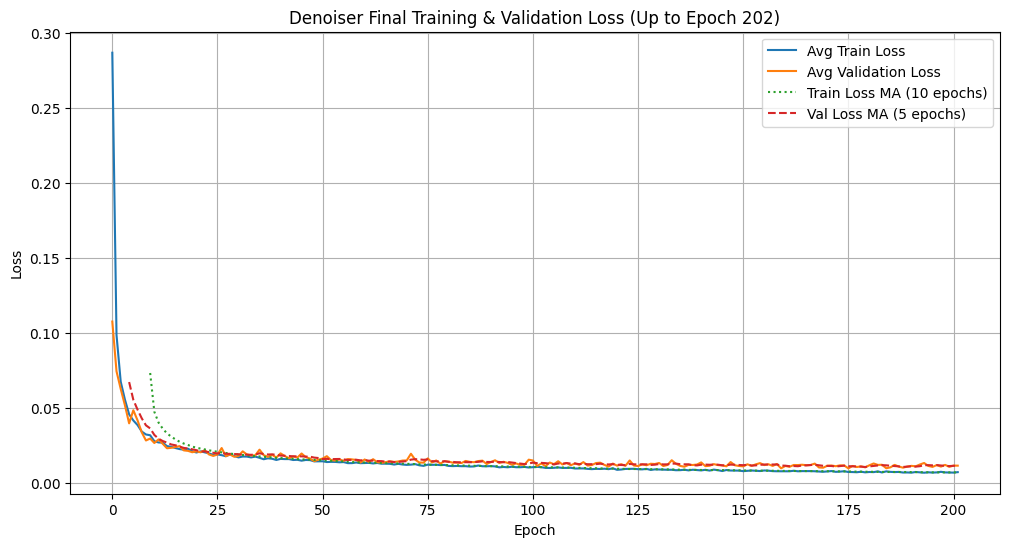

In [10]:
print("--- Starting Training Process ---")
overall_training_start_time = time.time() 

all_train_losses_for_plot = [] 
all_val_losses_for_plot = []   

train_loss_moving_avg_q = deque(maxlen=TRAIN_MOVING_AVG_WINDOW)
best_train_loss_ma = BEST_TRAIN_LOSS_MA_FROM_CKPT 
epochs_without_improvement_train = 0
previous_best_train_model_path = PREVIOUS_BEST_TRAIN_MODEL_PATH 

val_loss_moving_avg_q = deque(maxlen=VAL_MOVING_AVG_WINDOW)
final_epoch_completed = START_EPOCH -1 # Corrected initialization

for epoch in range(START_EPOCH, NUM_EPOCHS):
    epoch_start_time = time.time()
    current_epoch_num_for_log = epoch + 1
    # final_epoch_completed = epoch # Moved to end of loop for correct value if early stopping

    avg_train_loss = train_denoiser_epoch(
        denoiser, train_dataloader, optimizer,
        GRAD_CLIP_VALUE, DEVICE, current_epoch_num_for_log
    )
    all_train_losses_for_plot.append(avg_train_loss)
    train_loss_moving_avg_q.append(avg_train_loss)
    current_train_moving_avg = sum(train_loss_moving_avg_q) / len(train_loss_moving_avg_q) if train_loss_moving_avg_q else float('inf')

    avg_val_loss = validate_denoiser_epoch(
        denoiser, val_dataloader, DEVICE, current_epoch_num_for_log
    )
    all_val_losses_for_plot.append(avg_val_loss)
    val_loss_moving_avg_q.append(avg_val_loss) 
    current_val_moving_avg = sum(val_loss_moving_avg_q) / len(val_loss_moving_avg_q) if val_loss_moving_avg_q else float('inf')

    epoch_duration_seconds = time.time() - epoch_start_time
    epoch_duration_formatted = str(datetime.timedelta(seconds=epoch_duration_seconds))

    print(f"Epoch {current_epoch_num_for_log}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f} (MA: {current_train_moving_avg:.4f}), Val Loss: {avg_val_loss:.4f} (MA: {current_val_moving_avg:.4f}), Duration: {epoch_duration_formatted}")

    if lr_scheduler: lr_scheduler.step(avg_val_loss if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) else None)

    should_stop_early = False
    # Early stopping logic (using EARLY_STOPPING_MIN_EPOCHS correctly)
    if current_epoch_num_for_log > EARLY_STOPPING_MIN_EPOCHS: # Check after min epochs completed
        if current_train_moving_avg < best_train_loss_ma : 
            # ... (rest of early stopping logic seems okay, ensure it uses current_epoch_num_for_log correctly)
            improvement_over_absolute_best = (best_train_loss_ma - current_train_moving_avg) / abs(best_train_loss_ma + 1e-9) * 100
            print(f"  Train Loss MA improved to {current_train_moving_avg:.6f} from {best_train_loss_ma:.6f} ({improvement_over_absolute_best:.2f}% improvement).")
            best_train_loss_ma = current_train_moving_avg
            epochs_without_improvement_train = 0
            new_best_model_path = os.path.join(config.CHECKPOINT_DIR, "denoiser_model_best_train_loss.pth")
            torch.save({
                'epoch': epoch, 'model_state_dict': denoiser.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(), 'loss': avg_train_loss, 
                'val_loss': avg_val_loss, 'best_train_loss_ma': best_train_loss_ma
            }, new_best_model_path)
            print(f"  Saved new best model (train loss MA) at epoch {current_epoch_num_for_log}")
            if previous_best_train_model_path and previous_best_train_model_path != new_best_model_path and os.path.exists(previous_best_train_model_path):
                try: os.remove(previous_best_train_model_path); print(f"  Deleted previous best train model: {previous_best_train_model_path}")
                except OSError as e: print(f"  Warning: Could not delete previous best train model '{previous_best_train_model_path}': {e}")
            previous_best_train_model_path = new_best_model_path
        else: 
            epochs_without_improvement_train += 1
            print(f"  No improvement in train loss MA for {epochs_without_improvement_train} epoch(s). Best MA: {best_train_loss_ma:.6f}, Current MA: {current_train_moving_avg:.6f}")
            if epochs_without_improvement_train >= EARLY_STOPPING_PATIENCE:
                # ... (percentage improvement check)
                idx_before_streak_started = len(all_train_losses_for_plot) - epochs_without_improvement_train -1 # Index of the epoch before non-improvement streak
                # Ensure indices are valid
                if idx_before_streak_started >= 0:
                    # Calculate MA from historical_losses_for_ma of length TRAIN_MOVING_AVG_WINDOW ending at idx_before_streak_started
                    historical_window_start = max(0, idx_before_streak_started - TRAIN_MOVING_AVG_WINDOW + 1)
                    historical_losses_for_ma_calc = all_train_losses_for_plot[historical_window_start : idx_before_streak_started + 1]

                    if len(historical_losses_for_ma_calc) >= TRAIN_MOVING_AVG_WINDOW // 2 : # Need at least half window
                        historical_train_ma = sum(historical_losses_for_ma_calc) / len(historical_losses_for_ma_calc)
                        # Improvement is positive if current_train_moving_avg is smaller
                        percentage_improvement_vs_historical = (historical_train_ma - current_train_moving_avg) / abs(historical_train_ma + 1e-9) * 100
                        print(f"  Patience met. Current Train MA: {current_train_moving_avg:.6f}, Historical MA before streak ({len(historical_losses_for_ma_calc)} epochs): {historical_train_ma:.6f}. Improvement: {percentage_improvement_vs_historical:.2f}%")
                        if percentage_improvement_vs_historical < EARLY_STOPPING_PERCENTAGE:
                            should_stop_early = True
                            print(f"Early stopping triggered: Improvement {percentage_improvement_vs_historical:.2f}% < threshold {EARLY_STOPPING_PERCENTAGE}%.")
                    else:
                        print(f"  Patience met, but not enough historical data ({len(historical_losses_for_ma_calc)} points out of {TRAIN_MOVING_AVG_WINDOW}) to reliably calculate percentage improvement for early stopping.")
                else:
                     print(f"  Patience met, but not enough historical data (idx_before_streak_started = {idx_before_streak_started}) to compare.")

    
    if (current_epoch_num_for_log % SAVE_MODEL_EVERY == 0) or (epoch == NUM_EPOCHS - 1):
        is_best_this_epoch = current_train_moving_avg == best_train_loss_ma # Check if current MA is the best overall
        # Avoid saving regular checkpoint if it's also the best_train_loss epoch to prevent duplicate saves
        if not (is_best_this_epoch and os.path.join(config.CHECKPOINT_DIR, "denoiser_model_best_train_loss.pth") == previous_best_train_model_path):
             torch.save({
                'epoch': epoch, 'model_state_dict': denoiser.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(), 'loss': avg_train_loss,
                'val_loss': avg_val_loss, 'best_train_loss_ma': best_train_loss_ma # Save current best_train_loss_ma
            }, os.path.join(config.CHECKPOINT_DIR, f"denoiser_model_epoch_{current_epoch_num_for_log:04d}.pth"))
             print(f"Saved model checkpoint at epoch {current_epoch_num_for_log}")
    
    final_epoch_completed = epoch # Update last completed epoch here
    if should_stop_early: break

    if (current_epoch_num_for_log % SAMPLE_EVERY == 0) or (epoch == NUM_EPOCHS - 1):
        print(f"Epoch {current_epoch_num_for_log}: Generating visualization samples...")
        denoiser.eval()
        try: 
            vis_batch_target_img, vis_batch_act_single, vis_batch_prev_frames_flat = next(iter(val_dataloader))
        except StopIteration: 
            val_dataloader_iter = iter(DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)); 
            vis_batch_target_img, vis_batch_act_single, vis_batch_prev_frames_flat = next(val_dataloader_iter)
        
        n_vis_samples = min(4, vis_batch_target_img.shape[0])
        
        # Prepare inputs for DiffusionSampler.sample(prev_obs, prev_act)
        # 1. prev_obs: Needs to be (B, NumPrevFrames, C, H, W) for the sampler's initial unpack
        prev_frames_flat_for_sampler = vis_batch_prev_frames_flat[:n_vis_samples].to(DEVICE) # Shape (B, NumPrevFrames*C, H, W)
        
        num_prev_frames_const = config.NUM_PREV_FRAMES
        img_channels_const = DM_IMG_CHANNELS
        img_h_const = config.IMAGE_SIZE
        img_w_const = config.IMAGE_SIZE
        
        prev_frames_for_sampler_input_5d = prev_frames_flat_for_sampler.view(
            n_vis_samples, 
            num_prev_frames_const, 
            img_channels_const, 
            img_h_const, 
            img_w_const
        )

        # 2. prev_act: (B, NumPrevFrames)
        action_single_for_sampler = vis_batch_act_single[:n_vis_samples].to(DEVICE) # (B, 1)
        action_sequence_for_sampler = action_single_for_sampler.repeat(1, config.NUM_PREV_FRAMES).long() # (B, NumPrevFrames)
        
        with torch.no_grad():
            generated_output = diffusion_sampler.sample(
                prev_obs=prev_frames_for_sampler_input_5d, # Pass the reshaped 5D tensor
                prev_act=action_sequence_for_sampler 
            )
        generated_sample_tensor = generated_output[0] 
        
        ground_truth_for_vis = vis_batch_target_img[:n_vis_samples].to(DEVICE) 
        
        save_visualization_samples(generated_sample_tensor, ground_truth_for_vis, current_epoch_num_for_log, config.SAMPLE_DIR, prefix="val_vis")
        denoiser.train()

    if (current_epoch_num_for_log % PLOT_EVERY == 0) or (epoch == NUM_EPOCHS - 1) or should_stop_early :
        plt.figure(figsize=(12, 6))
        plt.plot(all_train_losses_for_plot, label="Avg Train Loss")
        plt.plot(all_val_losses_for_plot, label="Avg Validation Loss")
        if len(all_train_losses_for_plot) >= TRAIN_MOVING_AVG_WINDOW:
            train_ma_plot = [sum(all_train_losses_for_plot[i-TRAIN_MOVING_AVG_WINDOW+1:i+1])/TRAIN_MOVING_AVG_WINDOW for i in range(TRAIN_MOVING_AVG_WINDOW-1, len(all_train_losses_for_plot))]
            plt.plot(range(TRAIN_MOVING_AVG_WINDOW-1, len(all_train_losses_for_plot)), train_ma_plot, label=f'Train Loss MA ({TRAIN_MOVING_AVG_WINDOW} epochs)', linestyle=':')
        if len(all_val_losses_for_plot) >= VAL_MOVING_AVG_WINDOW:
            val_ma_plot = [sum(all_val_losses_for_plot[i-VAL_MOVING_AVG_WINDOW+1:i+1])/VAL_MOVING_AVG_WINDOW for i in range(VAL_MOVING_AVG_WINDOW-1, len(all_val_losses_for_plot))]
            plt.plot(range(VAL_MOVING_AVG_WINDOW-1, len(all_val_losses_for_plot)), val_ma_plot, label=f'Val Loss MA ({VAL_MOVING_AVG_WINDOW} epochs)', linestyle='--')
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Progress (Epoch {current_epoch_num_for_log})")
        plt.legend(); plt.grid(True)
        plt.savefig(os.path.join(config.PLOT_DIR, f"loss_plot_epoch_{current_epoch_num_for_log:04d}.png"))
        plt.close()
        print(f"Saved loss plot up to epoch {current_epoch_num_for_log}")

overall_training_end_time = time.time()
total_training_duration_seconds = overall_training_end_time - overall_training_start_time
total_training_duration_formatted = str(datetime.timedelta(seconds=total_training_duration_seconds))

# final_epoch_completed is the last epoch index that ran (0-indexed)
print(f"--- Training Complete (Stopped after epoch {final_epoch_completed + 1}) ---") 
print(f"Total training duration: {total_training_duration_formatted}") 

# Final Plot
plt.figure(figsize=(12, 6))
plt.plot(all_train_losses_for_plot, label="Avg Train Loss")
plt.plot(all_val_losses_for_plot, label="Avg Validation Loss")
if len(all_train_losses_for_plot) >= TRAIN_MOVING_AVG_WINDOW:
    train_ma_plot = [sum(all_train_losses_for_plot[i-TRAIN_MOVING_AVG_WINDOW+1:i+1])/TRAIN_MOVING_AVG_WINDOW for i in range(TRAIN_MOVING_AVG_WINDOW-1, len(all_train_losses_for_plot))]
    plt.plot(range(TRAIN_MOVING_AVG_WINDOW-1, len(all_train_losses_for_plot)), train_ma_plot, label=f'Train Loss MA ({TRAIN_MOVING_AVG_WINDOW} epochs)', linestyle=':')
if len(all_val_losses_for_plot) >= VAL_MOVING_AVG_WINDOW:
    val_ma_plot = [sum(all_val_losses_for_plot[i-VAL_MOVING_AVG_WINDOW+1:i+1])/VAL_MOVING_AVG_WINDOW for i in range(VAL_MOVING_AVG_WINDOW-1, len(all_val_losses_for_plot))]
    plt.plot(range(VAL_MOVING_AVG_WINDOW-1, len(all_val_losses_for_plot)), val_ma_plot, label=f'Val Loss MA ({VAL_MOVING_AVG_WINDOW} epochs)', linestyle='--')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Denoiser Final Training & Validation Loss (Up to Epoch {final_epoch_completed + 1})")
plt.legend(); plt.grid(True)
final_loss_plot_path = os.path.join(config.PLOT_DIR, "denoiser_final_loss_plot.png")
plt.savefig(final_loss_plot_path)
# plt.show() # Usually not needed in script, but can be uncommented for interactive
print(f"Final loss plot saved to {final_loss_plot_path}")
